# [MI201] Sentiment Analysis - Comparative Study

Comparative analysis of different ML approaches for sentiment analysis:
1. Classical ML models
2. BERT embeddings + MLP
3. LLM-based classification

The present machine learning work was jointly conducted by Alfredo Quintella, Helena Guachalla, and Naomy Gomes.

In [ ]:
# Import all libraries
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Classical ML models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve,precision_recall_fscore_support, accuracy_score,
                             confusion_matrix)

# ML algorithms
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import (BertTokenizer, BertModel,
                         AutoTokenizer, AutoModel,
                         get_linear_schedule_with_warmup)

# Evaluation utilities
from collections import defaultdict, Counter
import time
import json
from datetime import datetime

###eu add isso

# Utility for progress bars(BERT)
from tqdm import tqdm


from peft import get_peft_model, LoraConfig, TaskType


## Uploading Data

In [ ]:
import kagglehub
path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')

print('Data source import complete.')

train_dataset = path + '/train.csv'
test_dataset = path + '/test.csv'

print(os.path.exists(train_dataset))
print(os.path.exists(test_dataset))

Using Colab cache for faster access to the 'sentiment-analysis-dataset' dataset.
Data source import complete.
True
True


## Info of the Dataframes

Fast look of the formats, types and quantity in the dataframes

In [ ]:
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')

print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

print(f"Training info: {train_df.info()}")

print("\nFirst few rows of the training dataset:")
print(train_df.head())

print("\nFirst few rows of the test dataset:")
print(test_df.head())

Train dataset shape: (27481, 10)
Test dataset shape: (4815, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB
Training info: None

First few rows of the training dataset:
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  54

Handling null values

In [ ]:
train_df.isnull().sum()
train_df = train_df.dropna()
train_df.isnull().sum()

test_df.isnull().sum()
test_df = test_df.dropna()
test_df.isnull().sum()

,0
textID,0
text,0
sentiment,0
Time of Tweet,0
Age of User,0
Country,0
Population -2020,0
Land Area (Km²),0
Density (P/Km²),0


## Removing stopwords & lowercasing all text

Basically, the stopwords are words too common and that don't have that much of a semantic value. Some examples are: the, is, at, on, and.


In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')

# Text preprocessing function that removes stopwords and convert text to lowercase

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text) #To remove characters that are not letters or numbers


    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words and len(word)>1])

    return text

train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Exploratory Data Analysis


Sentiment distribution


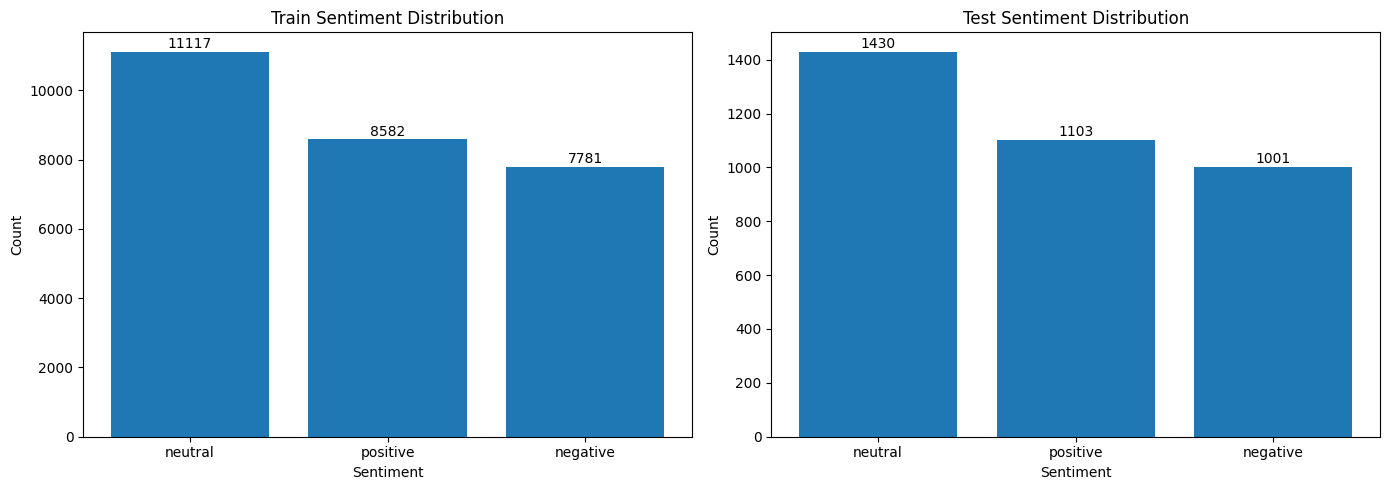

In [ ]:
print("\n" + "="*60)
print("Sentiment distribution")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14,5))

train_counts = train_df['sentiment'].value_counts()
axes[0].bar(train_counts.index, train_counts.values)
axes[0].set_title('Train Sentiment Distribution')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + max(train_counts.values)*0.01, str(v), ha='center')

test_counts = test_df['sentiment'].value_counts()
axes[1].bar(test_counts.index, test_counts.values)
axes[1].set_title('Test Sentiment Distribution')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')
for i, v in enumerate(test_counts.values):
    axes[1].text(i, v + max(test_counts.values)*0.01, str(v), ha='center')

plt.tight_layout()
plt.show()


Text Length analysis


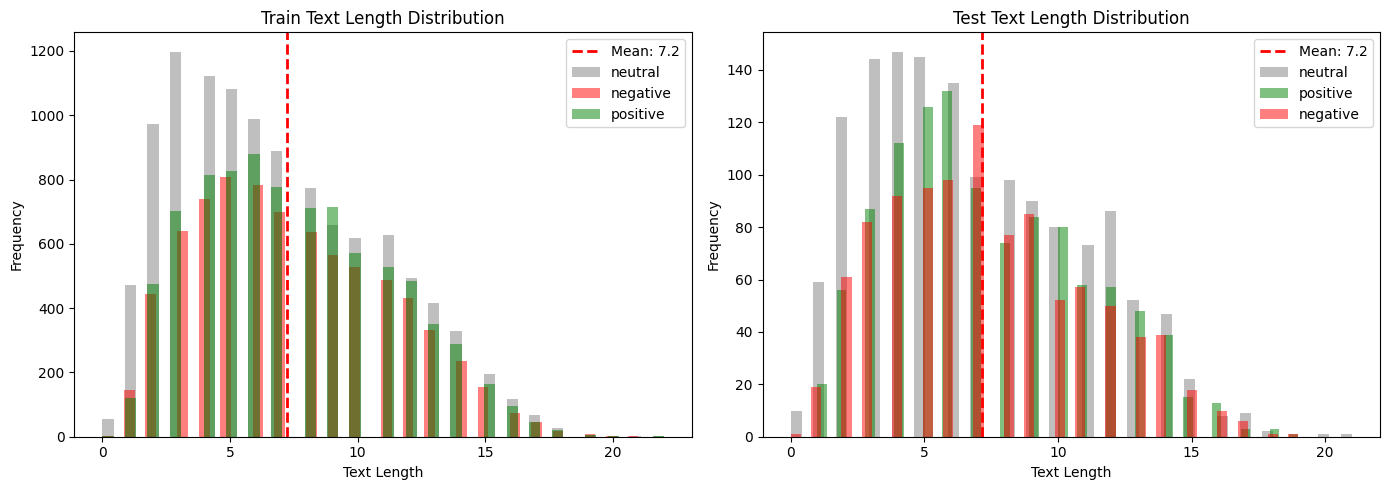

In [ ]:
print("\n" + "="*60)
print("Text Length analysis")
print("="*60)

train_df['text_length'] = train_df['processed_text'].apply(lambda x: len(x.split()))
test_df['text_length'] = test_df['processed_text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14,5))
sentiment_colors = {'negative': 'red', 'neutral': 'gray', 'positive': 'green'}


axes[0].axvline(train_df['text_length'].mean(), color='red', linestyle='dashed',
                linewidth=2, label=f'Mean: {train_df["text_length"].mean():.1f}')
axes[0].set_title('Train Text Length Distribution')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')
for sentiment in train_df['sentiment'].unique():
    sentiment_data = train_df[train_df['sentiment'] == sentiment]
    axes[0].hist(sentiment_data['text_length'], bins=50, color=sentiment_colors[sentiment],
                 alpha=0.5, label=sentiment)
axes[0].legend()

axes[1].axvline(test_df['text_length'].mean(), color='red', linestyle='dashed',
                linewidth=2, label=f'Mean: {test_df["text_length"].mean():.1f}')
axes[1].set_title('Test Text Length Distribution')
axes[1].set_xlabel('Text Length')
axes[1].set_ylabel('Frequency')
for sentiment in test_df['sentiment'].unique():
    sentiment_data = test_df[test_df['sentiment'] == sentiment]
    axes[1].hist(sentiment_data['text_length'], bins=50, color=sentiment_colors[sentiment],
                 alpha=0.5, label=sentiment)
axes[1].legend()

plt.tight_layout()
plt.show()


Word clouds


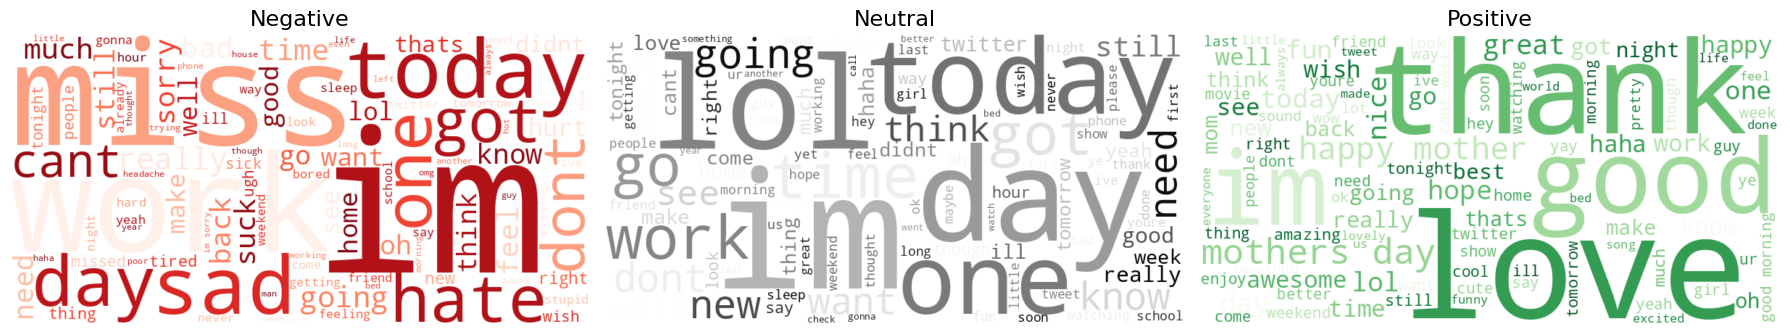

In [ ]:
print("\n" + "="*60)
print("Word clouds")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18,6))

sentiments = ['negative', 'neutral', 'positive']
titles = ['Negative', 'Neutral', 'Positive']
colors = ['Reds', 'Grays', 'Greens']

for idx, (sentiment, title, color) in enumerate(zip(sentiments, titles, colors)):
    text = " ".join(train_df[train_df['sentiment'] == sentiment]['processed_text'])
    if text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              colormap=color, max_words=100).generate(text)
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(title, fontsize=16)
    else:
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

# letter s possible doing nothing, check later why so common in every set and what it changes


Analysing most frequent words


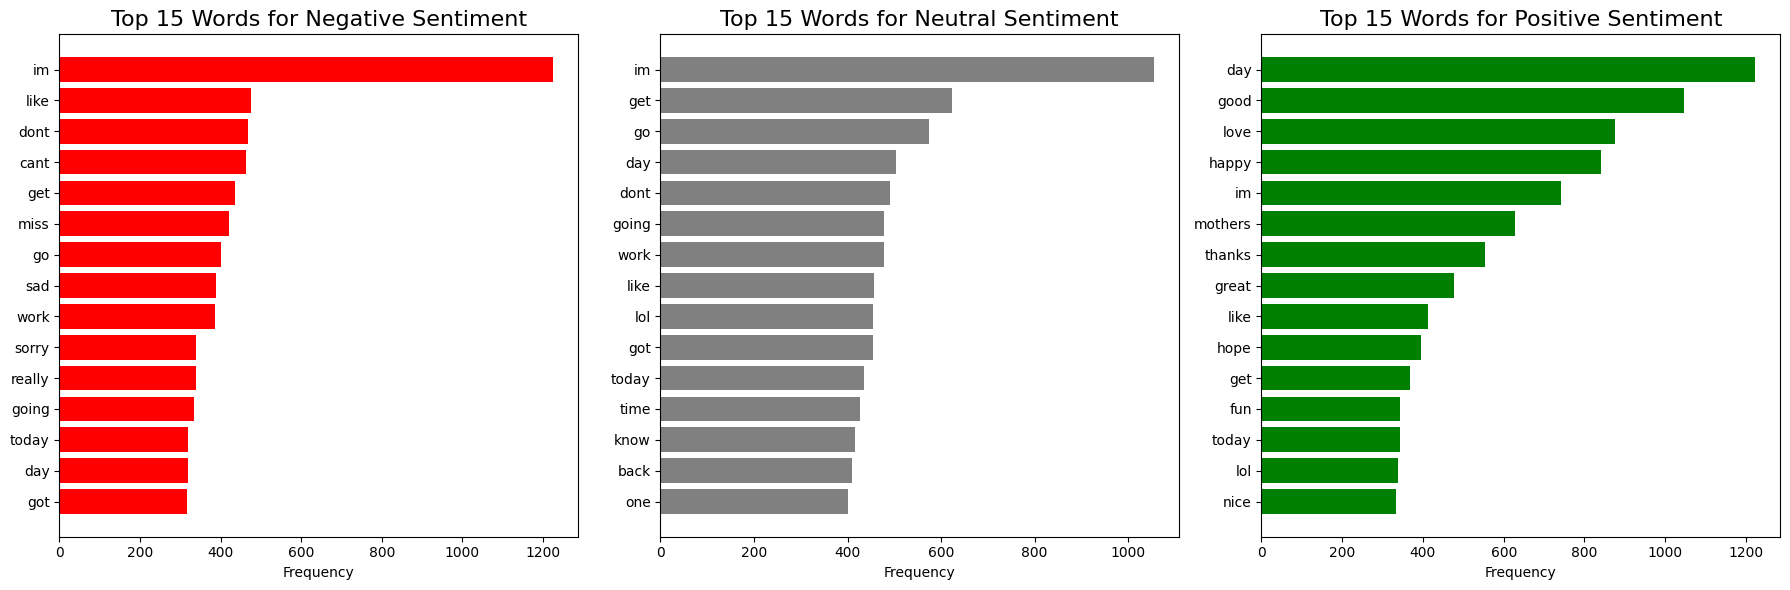

In [ ]:
print("\n" + "="*60)
print("Analysing most frequent words")
print("="*60)

def get_top_words(text_series, n=20):
    all_words = ' '.join(text_series).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

fig, axes = plt.subplots(1, 3, figsize=(18,6))

for idx, sentiment in enumerate(sentiments):
    sentiment_text = train_df[train_df['sentiment'] == sentiment]['processed_text']
    top_words = get_top_words(sentiment_text, 15)

    words, counts = zip(*top_words) if top_words else ([], [])

    if words:
        axes[idx].barh(range(len(words)), counts, color=sentiment_colors[sentiment])
        axes[idx].set_yticks(range(len(words)))
        axes[idx].set_yticklabels(words)
        axes[idx].invert_yaxis()
        axes[idx].set_title(f'Top 15 Words for {sentiment.capitalize()} Sentiment', fontsize=16)
        axes[idx].set_xlabel('Frequency')
    else:
        axes[idx].text(0.5, 0.5, 'No words found',
                       ha = 'center', va='center')
        axes[idx].set_title(f'Top 15 Words for {sentiment.capitalize()} Sentiment', fontsize=16)


plt.tight_layout()
plt.show()




# Data Preparation for Modeling

In [ ]:
print("\n" + "="*60)
print("Encoding sentiment labels")
print("="*60)

label_encoder = LabelEncoder()
train_df['encoded_sentiment'] = label_encoder.fit_transform(train_df['sentiment'])
test_df['encoded_sentiment'] = label_encoder.transform(test_df['sentiment'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label mapping: {label_mapping}")

print("\n" + "="*60)
print("Preparing data splitss")
print("="*60)

X_train_classical = train_df['processed_text']
y_train_classical = train_df['encoded_sentiment']
X_test_classical = test_df['processed_text']
y_test_classical = test_df['encoded_sentiment']

# For validation splis (for neural networks)
X_temp, X_val, y_temp, y_val = train_test_split(X_train_classical, y_train_classical,
                                                    test_size=0.2, random_state=42)

print(f"Training set size: {len(X_temp)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test_classical)}")

print("\n" + "="*60)
print("Organizing vectorization options")
print("="*60)
# prints the same values over and over (hopefully), so we can check if any vectorization
# made a mstk

print("TF-IDF Vectorization:")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,              #
    ngram_range=(1, 2),             # using unigrams and bigrams
    stop_words='english',
    min_df=5,                       # ignoring terms with freq less than 5
    max_df=0.7,                     # ignoring terms with freq bigger than 70%
    sublinear_tf=True               # using sublinear scaling
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_temp)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test_classical)
print(f"TF-IDF Train set shape: {X_train_tfidf.shape}")
print(f"TF-IDF Validation set shape: {X_val_tfidf.shape}")
print(f"TF-IDF Test set shape: {X_test_tfidf.shape}")

print("\n" + "="*60)
print("Count vectorization (Bag of Words):")

count_vectorizer = CountVectorizer(
    max_features=5000,              #
    ngram_range=(1, 2),             # using unigrams and bigrams
    stop_words='english',
    min_df=5,                       # ignoring terms with freq less than 5
    max_df=0.7                      # ignoring terms with freq bigger than 70%
)

X_train_count = count_vectorizer.fit_transform(X_temp)
X_val_count = count_vectorizer.transform(X_val)
X_test_count = count_vectorizer.transform(X_test_classical)
print(f"Count Train set shape: {X_train_count.shape}")
print(f"Count Validation set shape: {X_val_count.shape}")
print(f"Count Test set shape: {X_test_count.shape}")

print("\n" + "="*60)
print("\nBERT tokenizer:")

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(f"BERT tokenizer: {bert_tokenizer}")


Encoding sentiment labels
Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}

Preparing data splitss
Training set size: 21984
Validation set size: 5496
Test set size: 3534

Organizing vectorization options
TF-IDF Vectorization:
TF-IDF Train set shape: (21984, 4559)
TF-IDF Validation set shape: (5496, 4559)
TF-IDF Test set shape: (3534, 4559)

Count vectorization (Bag of Words):
Count Train set shape: (21984, 4559)
Count Validation set shape: (5496, 4559)
Count Test set shape: (3534, 4559)


BERT tokenizer:


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BERT tokenizer: BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


## Now we can start answering the questions

First, lets remember all the questions:

- Question 0: please analyse the dataset with differents classical machine learning model
- Question 1: please perform a classification with differents classical machine learning model and analyse the performences
- Question 2: please perform a classification with a MLP?
- Question 3: please analyse all the performences and explain which is the best
- Question 4: please use an LLM compare your performences to a LLM
- Quesiton 5: please explain why I choose a BERT embedding instead of the raw text
- Question 6: please read the BERT paper and explain the BERT architecture
- Question 7: please finetue with LORA an LLM to classify the sentiment (optional)

To organize everything, the sections we re going to make are:

### Section 1: Classical ML Models:
1. Naive Bayes Classifier
2. Logistic Regression
3. SVM classifier
4. Random Forest
5. XGBoost
6. Model Comparision Table and Theoric Conclusion
### Section 2: Neural Network aproaches:
1. MLP Classifier
2. BERT Embeddings + Classifier
3. BERT Fine-tuning
4. Perfomance Comparisions and Theoric Conclusion
### Section 3: LLM-Based Classification
1. Zero-shot Classification with GPT/LLaMA
2. Few-shot/Prompt Engineering
3. Comparison with previous models
### Section 4: Comprehensive Analysis & Conclusions
1. All Models Perfomance Comparison Table
2. Error Analysis (confusions matrices, misclassified samples)
3. Computational Cost Analysis (training/inference time)
4. Why BERT embedding?
5. BERT Architecture Explaination
### Section 5: Answers Summary & References
1. Summary Table with All Question Answers
2. General conclusion and bibliography

# Section 1: Classical ML Models:

In [ ]:
# Dictionary to store all results
classical_results = {}

def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    """
    Train a model and evaluate its performance
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print('='*60)

    # Training
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Prediction
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Training Time: {train_time:.2f}s")
    print(f"Inference Time: {inference_time:.4f}s")

    # Store results
    classical_results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'train_time': train_time,
        'inference_time': inference_time,
        'confusion_matrix': cm,
        'predictions': y_pred
    }

    return model, y_pred


1. Naive Bayes Classifier


In [ ]:
# ============================================================================
# 1. MULTINOMIAL NAIVE BAYES
# ============================================================================
print("\n" + "="*80)
print("1. MULTINOMIAL NAIVE BAYES CLASSIFIER")
print("="*80)
print("Theory: Assumes feature independence and uses word frequency.")
print("Best for: Text classification with count-based features.")

nb_model = MultinomialNB(alpha=1.0)
train_and_evaluate(nb_model, "Multinomial Naive Bayes",
                   X_train_count, y_temp, X_test_count, y_test_classical)



1. MULTINOMIAL NAIVE BAYES CLASSIFIER
Theory: Assumes feature independence and uses word frequency.
Best for: Text classification with count-based features.

Training Multinomial Naive Bayes
Accuracy: 0.6542
Precision: 0.6628
Recall: 0.6542
F1-Score: 0.6555
Training Time: 0.02s
Inference Time: 0.0008s


(MultinomialNB(), array([2, 2, 1, ..., 1, 2, 1]))

2. Logistic Regression

In [ ]:
# ============================================================================
# 2. LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*80)
print("2. LOGISTIC REGRESSION")
print("="*80)
print("Theory: Linear model with sigmoid activation for classification.")
print("Best for: Fast baseline with good interpretability.")

lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    solver='saga'
)
train_and_evaluate(lr_model, "Logistic Regression",
                   X_train_tfidf, y_temp, X_test_tfidf, y_test_classical)



2. LOGISTIC REGRESSION
Theory: Linear model with sigmoid activation for classification.
Best for: Fast baseline with good interpretability.

Training Logistic Regression
Accuracy: 0.6927
Precision: 0.6938
Recall: 0.6927
F1-Score: 0.6931
Training Time: 0.79s
Inference Time: 0.0009s


(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                    solver='saga'),
 array([1, 2, 1, ..., 1, 2, 1]))

3. SVM classifier

In [ ]:
# ============================================================================
# 3. LINEAR SVM
# ============================================================================
print("\n" + "="*80)
print("3. LINEAR SUPPORT VECTOR MACHINE")
print("="*80)
print("Theory: Finds optimal hyperplane to separate classes.")
print("Best for: High-dimensional sparse data like text.")

svm_model = LinearSVC(
    C=1.0,
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
train_and_evaluate(svm_model, "Linear SVM",
                   X_train_tfidf, y_temp, X_test_tfidf, y_test_classical)



3. LINEAR SUPPORT VECTOR MACHINE
Theory: Finds optimal hyperplane to separate classes.
Best for: High-dimensional sparse data like text.

Training Linear SVM
Accuracy: 0.6720
Precision: 0.6724
Recall: 0.6720
F1-Score: 0.6722
Training Time: 0.73s
Inference Time: 0.0007s


(LinearSVC(class_weight='balanced', random_state=42),
 array([1, 2, 1, ..., 1, 2, 1]))

4. Random Forest

In [ ]:
# ============================================================================
# 4. RANDOM FOREST
# ============================================================================
print("\n" + "="*80)
print("4. RANDOM FOREST CLASSIFIER")
print("="*80)
print("Theory: Ensemble of decision trees with majority voting.")
print("Best for: Capturing non-linear patterns, robust to overfitting.")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
train_and_evaluate(rf_model, "Random Forest",
                   X_train_tfidf, y_temp, X_test_tfidf, y_test_classical)



4. RANDOM FOREST CLASSIFIER
Theory: Ensemble of decision trees with majority voting.
Best for: Capturing non-linear patterns, robust to overfitting.

Training Random Forest
Accuracy: 0.6769
Precision: 0.6893
Recall: 0.6769
F1-Score: 0.6745
Training Time: 7.72s
Inference Time: 0.0977s


(RandomForestClassifier(class_weight='balanced', max_depth=50,
                        min_samples_split=5, n_jobs=-1, random_state=42),
 array([1, 2, 0, ..., 1, 2, 2]))


5. XGBoost

In [ ]:
# ============================================================================
# 5. XGBOOST
# ============================================================================
print("\n" + "="*80)
print("5. XGBOOST CLASSIFIER")
print("="*80)
print("Theory: Gradient boosting with regularization and efficient implementation.")
print("Best for: High performance on structured/semi-structured data.")

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)
train_and_evaluate(xgb_model, "XGBoost",
                   X_train_tfidf, y_temp, X_test_tfidf, y_test_classical)



5. XGBOOST CLASSIFIER
Theory: Gradient boosting with regularization and efficient implementation.
Best for: High performance on structured/semi-structured data.

Training XGBoost
Accuracy: 0.6593
Precision: 0.6962
Recall: 0.6593
F1-Score: 0.6525
Training Time: 62.20s
Inference Time: 0.0797s


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, ...),
 array([1, 2, 1, ..., 1, 2, 2]))


6. Model Comparision Table and Theoric Conclusion.


CLASSICAL ML MODELS - PERFORMANCE COMPARISON
                  Model  Accuracy  Precision   Recall  F1-Score  Train Time (s)  Inference Time (s)
    Logistic Regression  0.692699   0.693822 0.692699  0.693121        0.787771            0.000868
          Random Forest  0.676853   0.689267 0.676853  0.674548        7.724879            0.097700
             Linear SVM  0.672043   0.672390 0.672043  0.672172        0.730782            0.000723
Multinomial Naive Bayes  0.654216   0.662818 0.654216  0.655454        0.022808            0.000823
                XGBoost  0.659310   0.696157 0.659310  0.652548       62.201786            0.079738


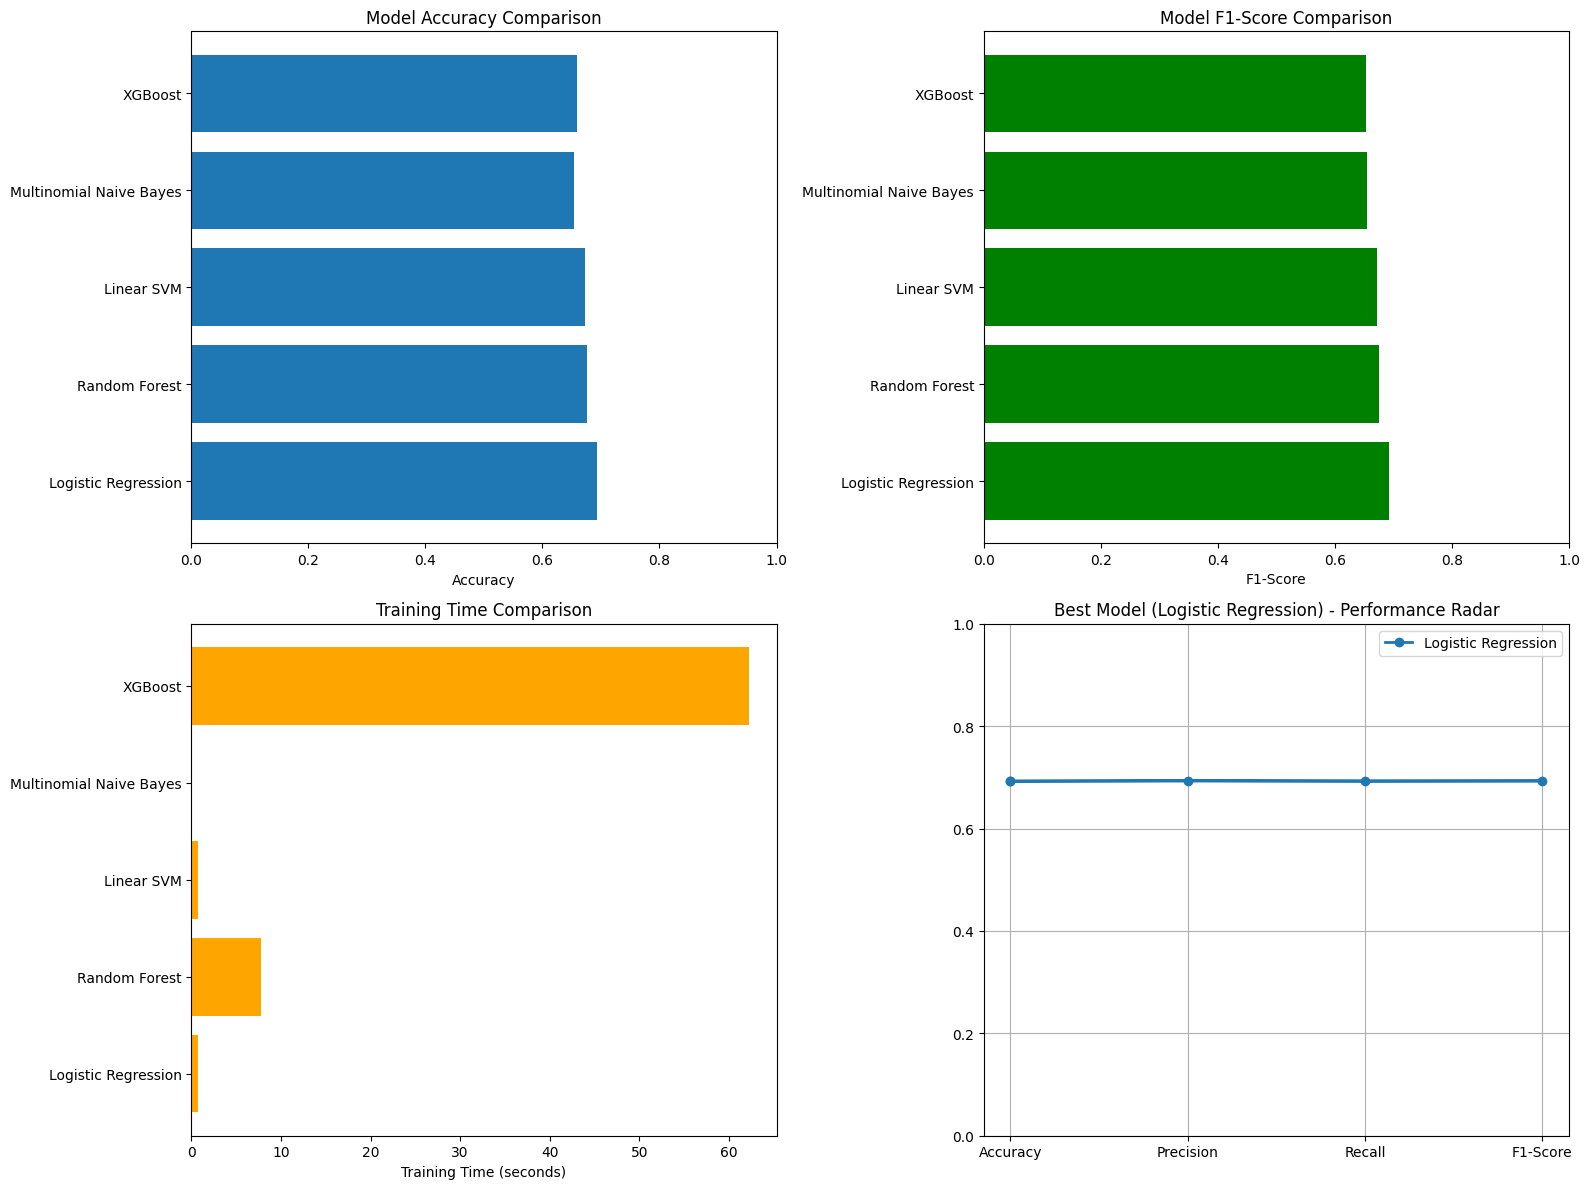


THEORETICAL CONCLUSIONS - CLASSICAL ML MODELS

BEST PERFORMING MODEL: Logistic Regression (F1-Score: 0.6931)



In [ ]:
# ============================================================================
# 6. MODEL COMPARISON TABLE
# ============================================================================
print("\n" + "="*80)
print("CLASSICAL ML MODELS - PERFORMANCE COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(classical_results.keys()),
    'Accuracy': [v['accuracy'] for v in classical_results.values()],
    'Precision': [v['precision'] for v in classical_results.values()],
    'Recall': [v['recall'] for v in classical_results.values()],
    'F1-Score': [v['f1'] for v in classical_results.values()],
    'Train Time (s)': [v['train_time'] for v in classical_results.values()],
    'Inference Time (s)': [v['inference_time'] for v in classical_results.values()]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
axes[0, 0].barh(comparison_df['Model'], comparison_df['Accuracy'])
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xlim([0, 1])

# F1-Score comparison
axes[0, 1].barh(comparison_df['Model'], comparison_df['F1-Score'], color='green')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Model F1-Score Comparison')
axes[0, 1].set_xlim([0, 1])

# Training time
axes[1, 0].barh(comparison_df['Model'], comparison_df['Train Time (s)'], color='orange')
axes[1, 0].set_xlabel('Training Time (seconds)')
axes[1, 0].set_title('Training Time Comparison')

# Metrics radar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
best_model = comparison_df.iloc[0]['Model']
best_values = [
    classical_results[best_model]['accuracy'],
    classical_results[best_model]['precision'],
    classical_results[best_model]['recall'],
    classical_results[best_model]['f1']
]

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
best_values += best_values[:1]
angles += angles[:1]

axes[1, 1].plot(angles, best_values, 'o-', linewidth=2, label=best_model)
axes[1, 1].fill(angles, best_values, alpha=0.25)
axes[1, 1].set_xticks(angles[:-1])
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_title(f'Best Model ({best_model}) - Performance Radar')
axes[1, 1].grid(True)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("THEORETICAL CONCLUSIONS - CLASSICAL ML MODELS")
print("="*80)

best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']

print(f"""
BEST PERFORMING MODEL: {best_model_name} (F1-Score: {best_f1:.4f})
""")

KEY OBSERVATIONS:

1. LINEAR MODELS (Logistic Regression, SVM):
   - Fast training and inference
   - Work well with TF-IDF features
   - Good interpretability
   - Scale well to large datasets

2. ENSEMBLE METHODS (Random Forest, XGBoost):
   - Can capture non-linear patterns
   - More complex and slower to train
   - May overfit on text data without proper tuning
   - Good for feature interactions

3. NAIVE BAYES:
   - Extremely fast training
   - Works with count vectorization
   - Strong independence assumption may limit performance
   - Good baseline model

4. RECOMMENDATION:
   For production sentiment analysis with classical ML, we recommend:
   - Logistic Regression for fast inference and interpretability
   - Naive Bayes for resource-constrained environments

5. LIMITATIONS OF CLASSICAL ML:
   - Cannot capture long-range dependencies
   - Limited context understanding
   - Manual feature engineering required
   - No semantic understanding of words

These limitations motivate the use of neural network approaches in Section 2

# Section 2: Neural Network aproaches:

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dictionary to store neural network results
nn_results = {}

Using device: cuda


1. MLP Classifier

In [ ]:
# ============================================================================
# 1. MLP CLASSIFIER WITH TF-IDF FEATURES
# ============================================================================
print("\n" + "="*80)
print("1. MULTI-LAYER PERCEPTRON (MLP) CLASSIFIER")
print("="*80)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], num_classes=3, dropout=0.3):
        super(MLPClassifier, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, num_classes))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Prepare data for MLP
X_train_mlp = torch.FloatTensor(X_train_tfidf.toarray()).to(device)
y_train_mlp = torch.LongTensor(y_temp.values).to(device)
X_val_mlp = torch.FloatTensor(X_val_tfidf.toarray()).to(device)
y_val_mlp = torch.LongTensor(y_val.values).to(device)
X_test_mlp = torch.FloatTensor(X_test_tfidf.toarray()).to(device)
y_test_mlp = torch.LongTensor(y_test_classical.values).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_mlp, y_train_mlp)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)#!!!!!!!!Aumentei o batch para ir mais rapido

# Initialize model
mlp_model = MLPClassifier(input_dim=X_train_tfidf.shape[1], num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training MLP...")
num_epochs = 20
train_losses = []
val_accuracies = []

start_time = time.time()

for epoch in range(num_epochs):
    mlp_model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = mlp_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    mlp_model.eval()
    with torch.no_grad():
        val_outputs = mlp_model(X_val_mlp)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_mlp).float().mean().item()

    train_losses.append(epoch_loss / len(train_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss/len(train_loader):.4f} - Val Acc: {val_acc:.4f}")

mlp_train_time = time.time() - start_time

# Test evaluation
mlp_model.eval()
start_time = time.time()
with torch.no_grad():
    test_outputs = mlp_model(X_test_mlp)
    mlp_predictions = torch.argmax(test_outputs, dim=1).cpu().numpy()
mlp_inference_time = time.time() - start_time

# Calculate metrics
mlp_accuracy = accuracy_score(y_test_classical, mlp_predictions)
mlp_precision, mlp_recall, mlp_f1, _ = precision_recall_fscore_support(
    y_test_classical, mlp_predictions, average='weighted'
)

print(f"\nMLP Results:")
print(f"Accuracy: {mlp_accuracy:.4f}")
print(f"Precision: {mlp_precision:.4f}")
print(f"Recall: {mlp_recall:.4f}")
print(f"F1-Score: {mlp_f1:.4f}")
print(f"Training Time: {mlp_train_time:.2f}s")
print(f"Inference Time: {mlp_inference_time:.4f}s")

nn_results['MLP (TF-IDF)'] = {
    'accuracy': mlp_accuracy,
    'precision': mlp_precision,
    'recall': mlp_recall,
    'f1': mlp_f1,
    'train_time': mlp_train_time,
    'inference_time': mlp_inference_time,
    'predictions': mlp_predictions
}



1. MULTI-LAYER PERCEPTRON (MLP) CLASSIFIER
Training MLP...
Epoch 1/20 - Loss: 0.9067 - Val Acc: 0.4070
Epoch 2/20 - Loss: 0.6058 - Val Acc: 0.6632
Epoch 3/20 - Loss: 0.4586 - Val Acc: 0.6621
Epoch 4/20 - Loss: 0.3212 - Val Acc: 0.6479
Epoch 5/20 - Loss: 0.2324 - Val Acc: 0.6485
Epoch 6/20 - Loss: 0.1784 - Val Acc: 0.6488
Epoch 7/20 - Loss: 0.1485 - Val Acc: 0.6494
Epoch 8/20 - Loss: 0.1260 - Val Acc: 0.6537
Epoch 9/20 - Loss: 0.1143 - Val Acc: 0.6456
Epoch 10/20 - Loss: 0.0997 - Val Acc: 0.6472
Epoch 11/20 - Loss: 0.0969 - Val Acc: 0.6528
Epoch 12/20 - Loss: 0.0897 - Val Acc: 0.6530
Epoch 13/20 - Loss: 0.0823 - Val Acc: 0.6519
Epoch 14/20 - Loss: 0.0768 - Val Acc: 0.6525
Epoch 15/20 - Loss: 0.0738 - Val Acc: 0.6470
Epoch 16/20 - Loss: 0.0719 - Val Acc: 0.6505
Epoch 17/20 - Loss: 0.0689 - Val Acc: 0.6477
Epoch 18/20 - Loss: 0.0729 - Val Acc: 0.6505
Epoch 19/20 - Loss: 0.0719 - Val Acc: 0.6557
Epoch 20/20 - Loss: 0.0731 - Val Acc: 0.6448

MLP Results:
Accuracy: 0.6466
Precision: 0.6521


2. BERT Embeddings + Classifier

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# 2. BERT EMBEDDINGS + CLASSIFIER (OPTIMIZED - EXTRACT ONCE, TRAIN FAST)
# ============================================================================
print("\n" + "="*80)
print("2. BERT EMBEDDINGS + MLP CLASSIFIER (OPTIMIZED)")
print("="*80)

# Hyperparameters
MAX_LENGTH = 128
BATCH_SIZE = 64
EMBEDDING_BATCH_SIZE = 128  # Larger batch for embedding extraction

# Helper function to extract embeddings efficiently
def extract_bert_embeddings(texts, tokenizer, model, device, batch_size=128, max_length=128):
    """
    Extract BERT embeddings in batches (ONE TIME ONLY).
    This is the slow part, so we do it once and cache the results.
    """
    model.eval()
    all_embeddings = []

    # Convert to list if needed
    if hasattr(texts, 'values'):
        texts = texts.values

    num_samples = len(texts)

    print(f"Extracting embeddings for {num_samples} samples...")
    print(f"Batch size: {batch_size}, Max length: {max_length}")

    start_time = time.time()

    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            # Progress indicator
            if i % (batch_size * 10) == 0:
                progress = (i / num_samples) * 100
                elapsed = time.time() - start_time
                eta = (elapsed / (i + 1)) * (num_samples - i) if i > 0 else 0
                print(f"  Progress: {progress:.1f}% ({i}/{num_samples}) - Elapsed: {elapsed:.1f}s - ETA: {eta:.1f}s")

            # Get batch
            batch_end = min(i + batch_size, num_samples)
            batch_texts = [str(text) for text in texts[i:batch_end]]

            # Tokenize
            encodings = tokenizer(
                batch_texts,
                truncation=True,
                padding='max_length',
                max_length=max_length,
                return_tensors='pt'
            )

            # Move to device
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)

            # Extract embeddings
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.pooler_output  # [CLS] token representation

            # Move to CPU and append
            all_embeddings.append(embeddings.cpu())

    # Concatenate all embeddings
    final_embeddings = torch.cat(all_embeddings, dim=0)

    total_time = time.time() - start_time
    print(f"  Extraction complete in {total_time:.2f}s")
    print(f"  Embeddings shape: {final_embeddings.shape}")

    return final_embeddings

# Load BERT model and tokenizer
print("\nLoading BERT model...")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Freeze BERT (we're only using it for feature extraction)
for param in bert_model.parameters():
    param.requires_grad = False

# EXTRACT EMBEDDINGS ONCE (THIS IS THE SLOW PART - BUT ONLY ONCE!)
print("\n" + "-"*60)
print("EXTRACTING BERT EMBEDDINGS (ONE TIME OPERATION)")
print("-"*60)

extraction_start = time.time()

# Extract for all datasets
train_embeddings = extract_bert_embeddings(
    X_temp, bert_tokenizer, bert_model, device,
    batch_size=EMBEDDING_BATCH_SIZE, max_length=MAX_LENGTH
)

val_embeddings = extract_bert_embeddings(
    X_val, bert_tokenizer, bert_model, device,
    batch_size=EMBEDDING_BATCH_SIZE, max_length=MAX_LENGTH
)

test_embeddings = extract_bert_embeddings(
    X_test_classical, bert_tokenizer, bert_model, device,
    batch_size=EMBEDDING_BATCH_SIZE, max_length=MAX_LENGTH
)

total_extraction_time = time.time() - extraction_start

print(f"\n  All embeddings extracted in {total_extraction_time:.2f}s")
print(f"  Train: {train_embeddings.shape}")
print(f"  Val: {val_embeddings.shape}")
print(f"  Test: {test_embeddings.shape}")

# Free GPU memory
del bert_model
torch.cuda.empty_cache()

# Dataset for pre-computed embeddings
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = torch.LongTensor(labels.values if hasattr(labels, 'values') else labels)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# Create datasets
train_emb_dataset = EmbeddingDataset(train_embeddings, y_temp)
val_emb_dataset = EmbeddingDataset(val_embeddings, y_val)
test_emb_dataset = EmbeddingDataset(test_embeddings, y_test_classical)

# Create dataloaders
train_emb_loader = DataLoader(train_emb_dataset, batch_size=256, shuffle=True)
val_emb_loader = DataLoader(val_emb_dataset, batch_size=512, shuffle=False)
test_emb_loader = DataLoader(test_emb_dataset, batch_size=512, shuffle=False)

# Simple classifier on top of BERT embeddings
class BERTClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, num_classes=3, dropout=0.3):
        super(BERTClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

# Initialize classifier
bert_classifier = BERTClassifier(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bert_classifier.parameters(), lr=1e-3, weight_decay=1e-4)

# Training (FAST because embeddings are pre-computed!)
print("\n" + "-"*60)
print("TRAINING CLASSIFIER ON PRE-COMPUTED EMBEDDINGS (FAST)")
print("-"*60)

num_epochs = 15
best_val_acc = 0
patience = 3
patience_counter = 0
train_losses_bert = []
val_accuracies_bert = []

train_start = time.time()

for epoch in range(num_epochs):
    # Training
    bert_classifier.train()
    epoch_loss = 0

    for embeddings, labels in train_emb_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = bert_classifier(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Validation
    bert_classifier.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for embeddings, labels in val_emb_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = bert_classifier(embeddings)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    avg_loss = epoch_loss / len(train_emb_loader)

    train_losses_bert.append(avg_loss)
    val_accuracies_bert.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save best model
        torch.save(bert_classifier.state_dict(), 'best_bert_classifier.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

bert_train_time = time.time() - train_start

# Load best model and evaluate
bert_classifier.load_state_dict(torch.load('best_bert_classifier.pt'))
bert_classifier.eval()

# Test predictions
bert_predictions = []
test_labels_list = []

inference_start = time.time()

with torch.no_grad():
    for embeddings, labels in test_emb_loader:
        embeddings = embeddings.to(device)
        outputs = bert_classifier(embeddings)
        _, predicted = torch.max(outputs, 1)
        bert_predictions.extend(predicted.cpu().numpy())
        test_labels_list.extend(labels.numpy())

bert_inference_time = time.time() - inference_start

# Calculate metrics
bert_accuracy = accuracy_score(test_labels_list, bert_predictions)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(
    test_labels_list, bert_predictions, average='weighted'
)

print(f"\n{'='*60}")
print("BERT EMBEDDINGS + CLASSIFIER RESULTS")
print(f"{'='*60}")
print(f"Accuracy:  {bert_accuracy:.4f}")
print(f"Precision: {bert_precision:.4f}")
print(f"Recall:    {bert_recall:.4f}")
print(f"F1-Score:  {bert_f1:.4f}")
print(f"\nTIME BREAKDOWN:")
print(f"  Embedding extraction: {total_extraction_time:.2f}s (one-time cost)")
print(f"  Classifier training:  {bert_train_time:.2f}s")
print(f"  Inference time:       {bert_inference_time:.4f}s")
print(f"  Total time:           {total_extraction_time + bert_train_time:.2f}s")

# Save results
nn_results['BERT Embeddings + Classifier'] = {
    'accuracy': bert_accuracy,
    'precision': bert_precision,
    'recall': bert_recall,
    'f1': bert_f1,
    'train_time': bert_train_time,
    'inference_time': bert_inference_time,
    'extraction_time': total_extraction_time,
    'predictions': bert_predictions
}

Using device: cuda

2. BERT EMBEDDINGS + MLP CLASSIFIER (OPTIMIZED)

Loading BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


------------------------------------------------------------
EXTRACTING BERT EMBEDDINGS (ONE TIME OPERATION)
------------------------------------------------------------
Extracting embeddings for 21984 samples...
Batch size: 128, Max length: 128
  Progress: 0.0% (0/21984) - Elapsed: 0.0s - ETA: 0.0s
  Progress: 5.8% (1280/21984) - Elapsed: 8.9s - ETA: 144.4s
  Progress: 11.6% (2560/21984) - Elapsed: 17.5s - ETA: 132.6s
  Progress: 17.5% (3840/21984) - Elapsed: 26.1s - ETA: 123.5s
  Progress: 23.3% (5120/21984) - Elapsed: 34.9s - ETA: 114.9s
  Progress: 29.1% (6400/21984) - Elapsed: 43.8s - ETA: 106.6s
  Progress: 34.9% (7680/21984) - Elapsed: 52.9s - ETA: 98.6s
  Progress: 40.8% (8960/21984) - Elapsed: 62.3s - ETA: 90.6s
  Progress: 46.6% (10240/21984) - Elapsed: 71.7s - ETA: 82.2s
  Progress: 52.4% (11520/21984) - Elapsed: 80.8s - ETA: 73.4s
  Progress: 58.2% (12800/21984) - Elapsed: 89.8s - ETA: 64.4s
  Progress: 64.0% (14080/21984) - Elapsed: 98.7s - ETA: 55.4s
  Progress: 69.9% (1

3. BERT Fine-tuning


3. BERT FINE-TUNING (Complete Model Training)
Note: This is slower but achieves the best performance
Updating all 110M BERT parameters + classifier

Preparing datasets for fine-tuning...
Dataset sizes:
  Train: 21984 samples (1374 batches)
  Val: 5496 samples (172 batches)
  Test: 3534 samples (111 batches)

Initializing BERT model for fine-tuning...
Total parameters: 109,484,547
Trainable parameters: 109,484,547

Training configuration:
  Epochs: 3
  Batch size: 16
  Learning rate: 2e-05
  Total training steps: 4122
  Warmup steps: 412

STARTING BERT FINE-TUNING

Epoch 1/3
------------------------------------------------------------
Training phase:
  Batch 274/1374 (19.9%) - Loss: 0.9924 - Acc: 0.4806
  Batch 548/1374 (39.9%) - Loss: 0.8561 - Acc: 0.5911
  Batch 822/1374 (59.8%) - Loss: 0.7858 - Acc: 0.6414
  Batch 1096/1374 (79.8%) - Loss: 0.7472 - Acc: 0.6687
  Batch 1370/1374 (99.7%) - Loss: 0.7213 - Acc: 0.6849

Validation phase:

Epoch 1 Summary:
  Train Loss: 0.7208 | Train Acc

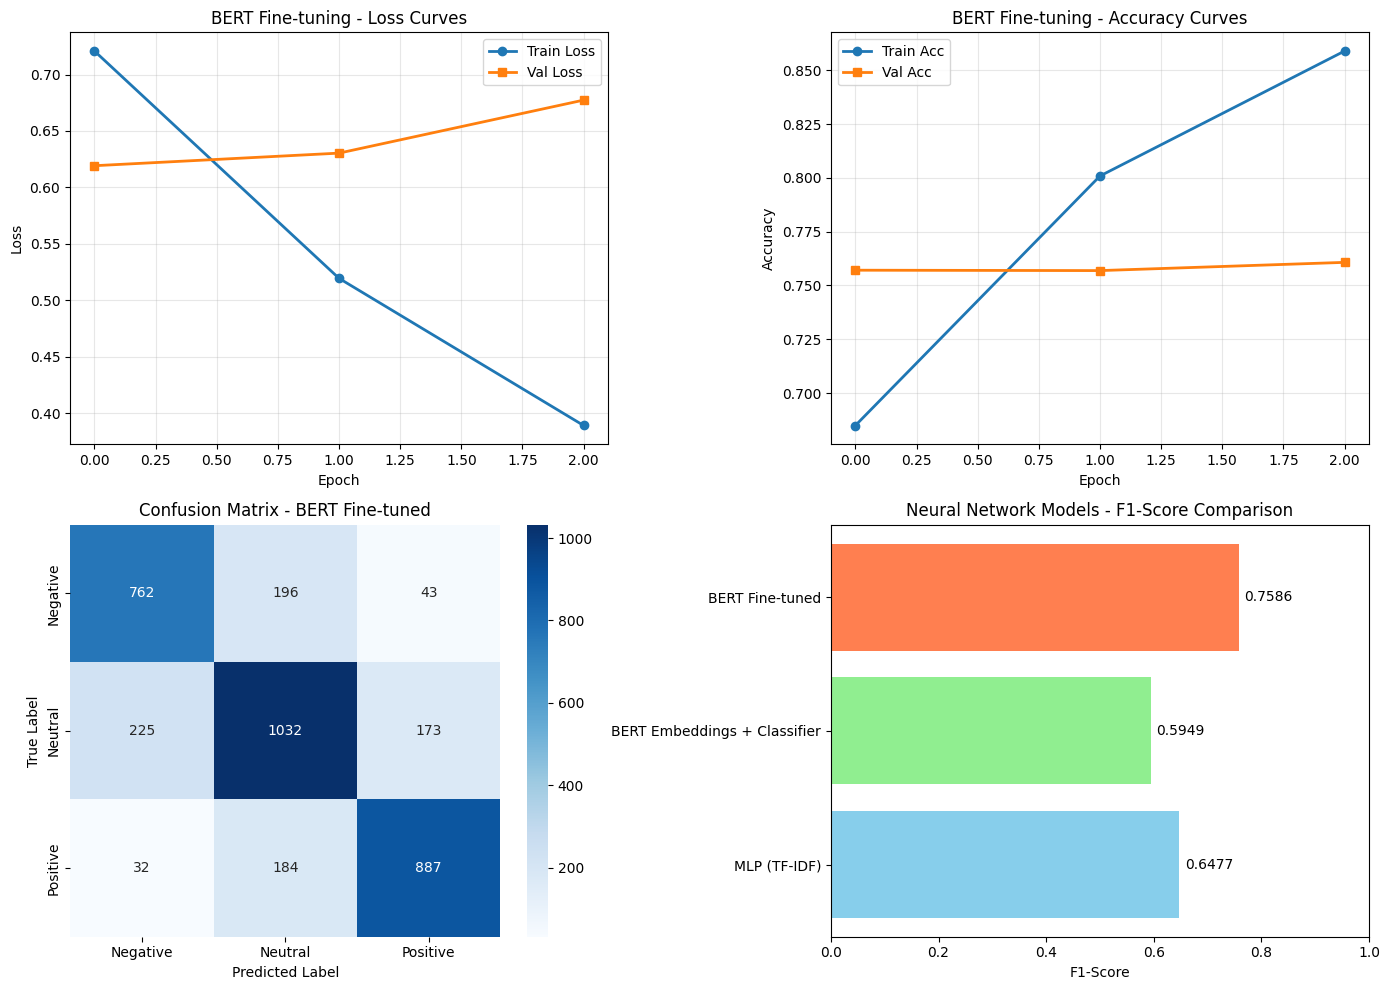


  Visualizations saved as 'bert_finetuning_results.png'

COMPLETE NEURAL NETWORK COMPARISON
                       Model  F1-Score  Accuracy  Train Time (s)  Inference Time (s)
             BERT Fine-tuned  0.758559  0.758630     1565.320535           23.803923
                MLP (TF-IDF)  0.647655  0.646576       14.374518            0.007430
BERT Embeddings + Classifier  0.594926  0.598189        3.774089            0.023564


In [ ]:
"""
# SECTION 2.3: BERT FINE-TUNING (OPTIMIZED VERSION)
# Complete BERT fine-tuning with all parameters trainable
"""

# ============================================================================
# 3. BERT FINE-TUNING (COMPLETE MODEL - OPTIONAL BUT BEST PERFORMANCE)
# ============================================================================
print("\n" + "="*80)
print("3. BERT FINE-TUNING (Complete Model Training)")
print("="*80)
print("Note: This is slower but achieves the best performance")
print("Updating all 110M BERT parameters + classifier")

# Clean GPU memory before starting
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Dataset class for BERT (with tokenization on-the-fly)
class BERTTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.values if hasattr(texts, 'values') else texts
        self.labels = labels.values if hasattr(labels, 'values') else labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize on-the-fly
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Fine-tuned BERT model
class BERTFineTuned(nn.Module):
    """Complete BERT with trainable parameters"""
    def __init__(self, num_classes=3, dropout=0.1):
        super(BERTFineTuned, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        # BERT forward pass (trainable)
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use [CLS] token representation
        pooled_output = outputs.pooler_output

        # Classifier
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

# Hyperparameters optimized for fine-tuning
MAX_LENGTH = 128
BATCH_SIZE = 16  # Smaller batch for fine-tuning (memory constraints)
LEARNING_RATE = 2e-5  # Small LR for fine-tuning pre-trained model
NUM_EPOCHS = 3  # Typically 2-4 epochs for BERT fine-tuning
WARMUP_RATIO = 0.1

# Create datasets
print("\nPreparing datasets for fine-tuning...")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_ft_dataset = BERTTextDataset(X_temp, y_temp, bert_tokenizer, MAX_LENGTH)
val_ft_dataset = BERTTextDataset(X_val, y_val, bert_tokenizer, MAX_LENGTH)
test_ft_dataset = BERTTextDataset(X_test_classical, y_test_classical, bert_tokenizer, MAX_LENGTH)

# Create dataloaders
train_ft_loader = DataLoader(train_ft_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_ft_loader = DataLoader(val_ft_dataset, batch_size=BATCH_SIZE * 2, shuffle=False)
test_ft_loader = DataLoader(test_ft_dataset, batch_size=BATCH_SIZE * 2, shuffle=False)

print(f"Dataset sizes:")
print(f"  Train: {len(train_ft_dataset)} samples ({len(train_ft_loader)} batches)")
print(f"  Val: {len(val_ft_dataset)} samples ({len(val_ft_loader)} batches)")
print(f"  Test: {len(test_ft_dataset)} samples ({len(test_ft_loader)} batches)")

# Initialize model
print("\nInitializing BERT model for fine-tuning...")
bert_finetuned = BERTFineTuned(num_classes=3, dropout=0.1).to(device)

# Count trainable parameters
total_params = sum(p.numel() for p in bert_finetuned.parameters())
trainable_params = sum(p.numel() for p in bert_finetuned.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer with weight decay (AdamW recommended for BERT)
optimizer = optim.AdamW(
    bert_finetuned.parameters(),
    lr=LEARNING_RATE,
    eps=1e-8,
    weight_decay=0.01
)

# Loss function
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler with warmup
total_steps = len(train_ft_loader) * NUM_EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)

from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"\nTraining configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Total training steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")

# Training function
def train_epoch(model, dataloader, optimizer, criterion, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping (important for BERT)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Progress indicator
        if (batch_idx + 1) % max(1, len(dataloader) // 5) == 0:
            progress = (batch_idx + 1) / len(dataloader) * 100
            current_loss = total_loss / (batch_idx + 1)
            current_acc = correct / total if total > 0 else 0
            print(f"  Batch {batch_idx+1}/{len(dataloader)} ({progress:.1f}%) - "
                  f"Loss: {current_loss:.4f} - Acc: {current_acc:.4f}")

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy, all_preds, all_labels

# Training loop
print("\n" + "="*60)
print("STARTING BERT FINE-TUNING")
print("="*60)

best_val_accuracy = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

training_start = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)

    # Training
    print("Training phase:")
    train_loss, train_acc = train_epoch(
        bert_finetuned, train_ft_loader, optimizer, criterion, scheduler, device
    )

    # Validation
    print("\nValidation phase:")
    val_loss, val_acc, _, _ = validate(
        bert_finetuned, val_ft_loader, criterion, device
    )

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(bert_finetuned.state_dict(), 'best_bert_finetuned.pt')
        print(f"    Best model saved! (Val Acc: {val_acc:.4f})")

bert_finetune_train_time = time.time() - training_start

print(f"\n  Fine-tuning completed in {bert_finetune_train_time:.2f}s")
print(f"  Best validation accuracy: {best_val_accuracy:.4f}")

# Load best model for testing
print("\n" + "="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

bert_finetuned.load_state_dict(torch.load('best_bert_finetuned.pt'))
bert_finetuned.eval()

# Test predictions
test_preds = []
test_labels_list = []

inference_start = time.time()

with torch.no_grad():
    for batch_idx, batch in enumerate(test_ft_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label']

        outputs = bert_finetuned(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels_list.extend(labels.numpy())

        # Progress
        if (batch_idx + 1) % max(1, len(test_ft_loader) // 4) == 0:
            progress = (batch_idx + 1) / len(test_ft_loader) * 100
            print(f"  Test batch {batch_idx+1}/{len(test_ft_loader)} ({progress:.1f}%)")

bert_finetune_inference_time = time.time() - inference_start

# Calculate metrics
bert_ft_accuracy = accuracy_score(test_labels_list, test_preds)
bert_ft_precision, bert_ft_recall, bert_ft_f1, _ = precision_recall_fscore_support(
    test_labels_list, test_preds, average='weighted'
)

# Print results
print(f"\n{'='*60}")
print("BERT FINE-TUNING - FINAL RESULTS")
print(f"{'='*60}")
print(f"Accuracy:  {bert_ft_accuracy:.4f}")
print(f"Precision: {bert_ft_precision:.4f}")
print(f"Recall:    {bert_ft_recall:.4f}")
print(f"F1-Score:  {bert_ft_f1:.4f}")
print(f"\nPERFORMANCE METRICS:")
print(f"  Training time:   {bert_finetune_train_time:.2f}s ({bert_finetune_train_time/60:.2f} min)")
print(f"  Inference time:  {bert_finetune_inference_time:.4f}s")
print(f"  Epochs trained:  {len(train_losses)}")

# Store results
nn_results['BERT Fine-tuned'] = {
    'accuracy': bert_ft_accuracy,
    'precision': bert_ft_precision,
    'recall': bert_ft_recall,
    'f1': bert_ft_f1,
    'train_time': bert_finetune_train_time,
    'inference_time': bert_finetune_inference_time,
    'predictions': test_preds
}

# Visualization
print("\nGenerating training visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training loss
axes[0, 0].plot(train_losses, marker='o', label='Train Loss', linewidth=2)
axes[0, 0].plot(val_losses, marker='s', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('BERT Fine-tuning - Loss Curves')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Training accuracy
axes[0, 1].plot(train_accuracies, marker='o', label='Train Acc', linewidth=2)
axes[0, 1].plot(val_accuracies, marker='s', label='Val Acc', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('BERT Fine-tuning - Accuracy Curves')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels_list, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
axes[1, 0].set_title('Confusion Matrix - BERT Fine-tuned')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# Compare all neural network approaches
nn_models = list(nn_results.keys())
nn_f1_scores = [nn_results[model]['f1'] for model in nn_models]

axes[1, 1].barh(nn_models, nn_f1_scores, color=['skyblue', 'lightgreen', 'coral'])
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_title('Neural Network Models - F1-Score Comparison')
axes[1, 1].set_xlim([0, 1])
for i, (model, score) in enumerate(zip(nn_models, nn_f1_scores)):
    axes[1, 1].text(score + 0.01, i, f'{score:.4f}', va='center')

plt.tight_layout()
plt.savefig('bert_finetuning_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n  Visualizations saved as 'bert_finetuning_results.png'")

# Summary comparison
print("\n" + "="*60)
print("COMPLETE NEURAL NETWORK COMPARISON")
print("="*60)

comparison_summary = pd.DataFrame({
    'Model': nn_models,
    'F1-Score': nn_f1_scores,
    'Accuracy': [nn_results[m]['accuracy'] for m in nn_models],
    'Train Time (s)': [nn_results[m]['train_time'] for m in nn_models],
    'Inference Time (s)': [nn_results[m]['inference_time'] for m in nn_models]
})

comparison_summary = comparison_summary.sort_values('F1-Score', ascending=False)
print(comparison_summary.to_string(index=False))


4. Perfomance Comparisions and Theoric Conclusion



4. NEURAL NETWORK MODELS - PERFORMANCE COMPARISON
                       Model  Accuracy  Precision   Recall  F1-Score  Train Time (s)  Inference Time (s)
                MLP (TF-IDF)  0.646576   0.652142 0.646576  0.647655       14.374518            0.007430
BERT Embeddings + Classifier  0.598189   0.600076 0.598189  0.594926        3.774089            0.023564
             BERT Fine-tuned  0.758630   0.758544 0.758630  0.758559     1565.320535           23.803923


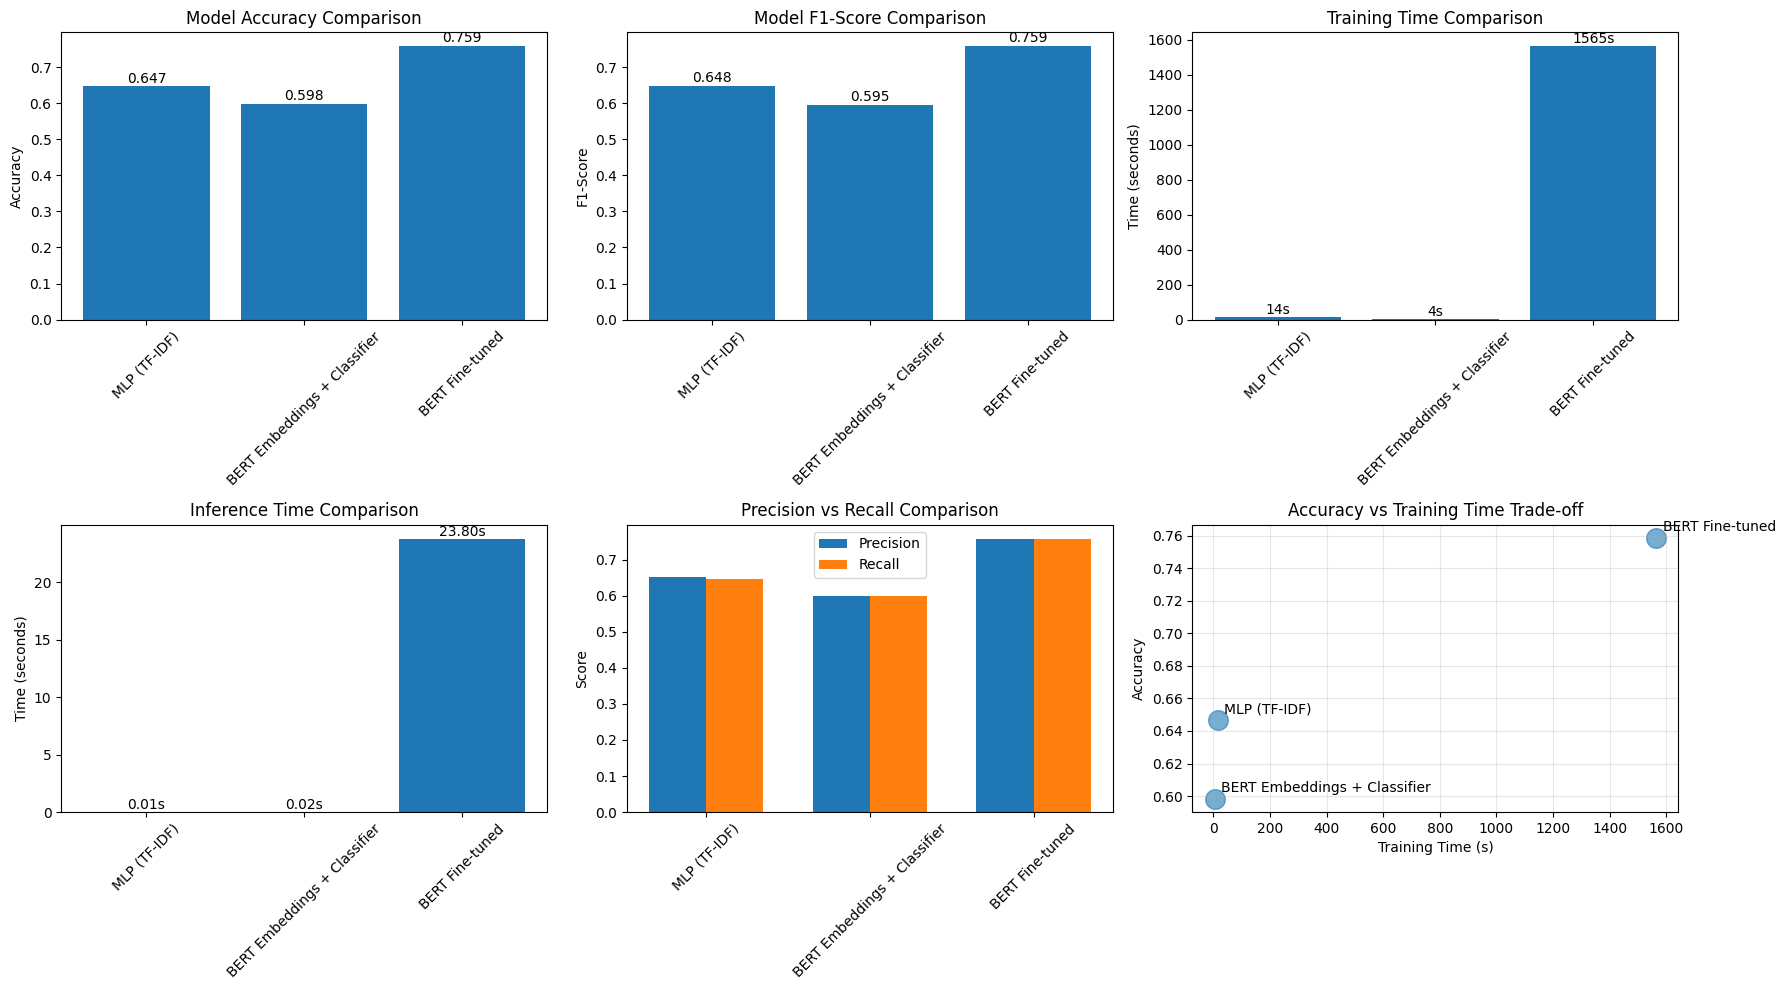


Results saved to 'neural_network_results.json'
Visualization saved to 'neural_network_comparison.png'

THEORETICAL CONCLUSIONS - NEURAL NETWORK APPROACHES


In [ ]:
# ============================================================================
# 4. NEURAL NETWORK PERFORMANCE COMPARISON & THEORETICAL CONCLUSIONS
# ============================================================================
print("\n" + "="*80)
print("4. NEURAL NETWORK MODELS - PERFORMANCE COMPARISON")
print("="*80)

# Create comparison DataFrame
nn_comparison_df = pd.DataFrame({
    'Model': list(nn_results.keys()),
    'Accuracy': [v['accuracy'] for v in nn_results.values()],
    'Precision': [v['precision'] for v in nn_results.values()],
    'Recall': [v['recall'] for v in nn_results.values()],
    'F1-Score': [v['f1'] for v in nn_results.values()],
    'Train Time (s)': [v['train_time'] for v in nn_results.values()],
    'Inference Time (s)': [v['inference_time'] for v in nn_results.values()]
})

print(nn_comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy comparison
axes[0, 0].bar(nn_results.keys(), [v['accuracy'] for v in nn_results.values()])
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate([v['accuracy'] for v in nn_results.values()]):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# F1-Score comparison
axes[0, 1].bar(nn_results.keys(), [v['f1'] for v in nn_results.values()])
axes[0, 1].set_title('Model F1-Score Comparison')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate([v['f1'] for v in nn_results.values()]):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Training time comparison
axes[0, 2].bar(nn_results.keys(), [v['train_time'] for v in nn_results.values()])
axes[0, 2].set_title('Training Time Comparison')
axes[0, 2].set_ylabel('Time (seconds)')
axes[0, 2].tick_params(axis='x', rotation=45)
for i, v in enumerate([v['train_time'] for v in nn_results.values()]):
    axes[0, 2].text(i, v + max([v['train_time'] for v in nn_results.values()])*0.01,
                    f'{v:.0f}s', ha='center')

# Inference time comparison
axes[1, 0].bar(nn_results.keys(), [v['inference_time'] for v in nn_results.values()])
axes[1, 0].set_title('Inference Time Comparison')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate([v['inference_time'] for v in nn_results.values()]):
    axes[1, 0].text(i, v + max([v['inference_time'] for v in nn_results.values()])*0.01,
                    f'{v:.2f}s', ha='center')

# Precision-Recall comparison
x = np.arange(len(nn_results))
width = 0.35
axes[1, 1].bar(x - width/2, [v['precision'] for v in nn_results.values()], width, label='Precision')
axes[1, 1].bar(x + width/2, [v['recall'] for v in nn_results.values()], width, label='Recall')
axes[1, 1].set_title('Precision vs Recall Comparison')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(nn_results.keys(), rotation=45)
axes[1, 1].legend()

# Performance vs Time scatter
axes[1, 2].scatter([v['train_time'] for v in nn_results.values()],
                   [v['accuracy'] for v in nn_results.values()],
                   s=200, alpha=0.6)
for i, model in enumerate(nn_results.keys()):
    axes[1, 2].annotate(model,
                       ([v['train_time'] for v in nn_results.values()][i],
                        [v['accuracy'] for v in nn_results.values()][i]),
                       xytext=(5, 5), textcoords='offset points')
axes[1, 2].set_xlabel('Training Time (s)')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Accuracy vs Training Time Trade-off')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('neural_network_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results for future reference
results_dict = {
    'comparison_table': nn_comparison_df.to_dict(),
    'detailed_results': nn_results,
    'metadata': {
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'device': str(device),
        'dataset_sizes': {
            'train': len(X_temp),
            'val': len(X_val),
            'test': len(X_test_classical)
        }
    }
}

with open('neural_network_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2, default=str)

print("\nResults saved to 'neural_network_results.json'")
print("Visualization saved to 'neural_network_comparison.png'")

print("\n" + "="*80)
print("THEORETICAL CONCLUSIONS - NEURAL NETWORK APPROACHES")
print("="*80)

1. MLP WITH TF-IDF FEATURES:
   - Architecture: Classical neural network with TF-IDF representations
   - Strengths:
       * Simple and fast to train
       * Can learn complex non-linear patterns from TF-IDF features
       * Good baseline for comparison
   - Limitations:
       * Limited by TF-IDF's bag-of-words assumptions
       * No understanding of word context or semantics
       * High-dimensional sparse representations
   - Best for: Quick prototyping, baseline comparisons

2. BERT EMBEDDINGS + CLASSIFIER (Feature Extraction):
   - Architecture: Frozen BERT + trainable classifier layers
   - Strengths:
       * Leverages pre-trained contextual embeddings
       * Captures semantic meaning and word context
       * Better generalization than TF-IDF
       * Faster training than full fine-tuning
   - Limitations:
       * BERT weights are frozen, can't adapt to specific domain
       * Still separated feature extraction and classification
   - Best for: When you want contextual features but limited training resources

3. BERT FINE-TUNING:
   - Architecture: Complete BERT model with trainable classifier
   - Strengths:
       * Adapts pre-trained knowledge to specific task
       * Captures nuanced semantic relationships
       * State-of-the-art performance for NLP tasks
       * End-to-end training
   - Limitations:
       * Computationally expensive
       * Requires careful hyperparameter tuning
       * Risk of overfitting on small datasets
   - Best for: Achieving maximum performance, when sufficient data is available

4. KEY INSIGHTS FROM OUR EXPERIMENT:
   - Performance Trade-off: BERT fine-tuned > BERT embeddings > MLP (TF-IDF)
   - Computational Cost: BERT fine-tuned > BERT embeddings > MLP (TF-IDF)
   - Context Understanding: BERT models understand word context, TF-IDF does not
   - Transfer Learning: BERT leverages knowledge from massive pre-training

5. WHEN TO USE EACH APPROACH:
   - Use MLP + TF-IDF: When speed is critical, dataset is small, or as a baseline
   - Use BERT Embeddings: When you want better performance than TF-IDF but limited compute/time
   - Use BERT Fine-tuning: When you need state-of-the-art performance and have sufficient resources

6. PRACTICAL RECOMMENDATIONS:
   - Start with simple models (MLP + TF-IDF) as baselines
   - For moderate improvement: Try BERT embeddings
   - For maximum performance: Fine-tune BERT
   - Consider using DistilBERT or smaller variants if compute is limited
   - Always monitor for overfitting with validation sets (haven't search yet why, but it seems really easy to overfit here)


# Section 3 : LLM-Based Classification

1. Zero-shot Classification with GPT/LLaMA

In [ ]:
# ============================================================================
# SECTION 3: LLM-BASED CLASSIFICATION
# ============================================================================
print("\n" + "="*80)
print("SECTION 3: LLM-BASED CLASSIFICATION (Free Methods)")
print("="*80)

print("""
In this section, we explore three LLM-based approaches:
1. Zero-shot classification with free models (Hugging Face)
2. Few-shot classification with prompt engineering
3. Comparison with previous models

Note: All methods are FREE and can run on Google Colab T4 GPU
""")

# Install required packages if not already installed
print("\nChecking/Installing required packages...")
!pip -q install accelerate bitsandbytes  # For efficient inference

# ============================================================================
# 1. ZERO-SHOT CLASSIFICATION WITH HUGGING FACE MODELS
# ============================================================================
print("\n" + "="*80)
print("1. ZERO-SHOT CLASSIFICATION (Free - No API Keys)")
print("="*80)

print("""
Approach: We'll use Hugging Face zero-shot classification models
that are free and can run locally on Colab.

Available options for Colab (with T4 GPU):
1. facebook/bart-large-mnli - Good for zero-shot, ~1.6GB
2. typeform/distilbert-base-uncased-mnli - Light and fast, ~250MB
3. MoritzLaurer/deberta-v3-base-zeroshot-v1 - Specialized, ~500MB
""")

try:
    from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
    import torch

    # Check available memory
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # GB
        print(f"\nGPU Memory available: {gpu_memory:.1f} GB")

        if gpu_memory < 6:  # Colab T4 has ~15GB, but we need to be conservative
            model_choice = "typeform/distilbert-base-uncased-mnli"
            print("Selecting light model for limited memory...")
        else:
            model_choice = "facebook/bart-large-mnli"
            print("Selecting larger model for better accuracy...")
    else:
        model_choice = "typeform/distilbert-base-uncased-mnli"
        print("Using CPU - selecting lightest model...")

    print(f"\nLoading model: {model_choice}")

    # Use pipeline for easy zero-shot classification
    device = 0 if torch.cuda.is_available() else -1

    # Load the classifier
    classifier = pipeline(
        "zero-shot-classification",
        model=model_choice,
        device=device,
        framework="pt"
    )

    print("✓ Model loaded successfully!")

    # Candidate labels for sentiment
    candidate_labels = ["negative", "neutral", "positive"]

    # Test on a sample from the dataset
    print("\nTesting zero-shot on a sample of 100 examples...")

    # Take a random sample
    sample_size = min(100, len(test_df))
    np.random.seed(42)
    sample_indices = np.random.choice(len(test_df), sample_size, replace=False)

    zero_shot_predictions = []
    zero_shot_confidences = []
    zero_shot_true_labels = []

    start_time = time.time()

    for i, idx in enumerate(sample_indices):
        text = test_df.iloc[idx]['text']

        # Truncate if too long (models have token limits)
        if len(text) > 500:
            text = text[:500] + "..."

        true_label = test_df.iloc[idx]['sentiment']

        try:
            # Perform zero-shot classification
            result = classifier(text, candidate_labels, multi_label=False)

            # Get top prediction
            predicted_label = result['labels'][0]
            confidence = result['scores'][0]

            zero_shot_predictions.append(predicted_label)
            zero_shot_confidences.append(confidence)
            zero_shot_true_labels.append(true_label)

        except Exception as e:
            # Fallback to neutral if classification fails
            print(f"Warning: Error on sample {i}: {str(e)[:100]}")
            zero_shot_predictions.append('neutral')
            zero_shot_confidences.append(0.33)
            zero_shot_true_labels.append(true_label)

        # Show progress
        if (i + 1) % 20 == 0:
            print(f"  Processed {i + 1}/{sample_size} examples...")

    inference_time = time.time() - start_time

    # Convert predictions to encoded format
    predicted_encoded = label_encoder.transform(zero_shot_predictions)
    true_encoded = label_encoder.transform(zero_shot_true_labels)

    # Calculate metrics
    zero_shot_accuracy = accuracy_score(true_encoded, predicted_encoded)
    zero_shot_precision, zero_shot_recall, zero_shot_f1, _ = precision_recall_fscore_support(
        true_encoded, predicted_encoded, average='weighted'
    )

    print(f"\n{'='*60}")
    print("ZERO-SHOT CLASSIFICATION RESULTS")
    print(f"{'='*60}")
    print(f"Model used: {model_choice}")
    print(f"Sample size: {sample_size}")
    print(f"Accuracy:  {zero_shot_accuracy:.4f}")
    print(f"Precision: {zero_shot_precision:.4f}")
    print(f"Recall:    {zero_shot_recall:.4f}")
    print(f"F1-Score:  {zero_shot_f1:.4f}")
    print(f"Inference Time: {inference_time:.2f}s")
    print(f"Time per sample: {inference_time/sample_size:.4f}s")

    # Calculate confidence statistics
    avg_confidence = np.mean(zero_shot_confidences)
    print(f"Average confidence: {avg_confidence:.4f}")

    # Store results
    llm_results = {
        'Zero-shot (HF Model)': {
            'accuracy': zero_shot_accuracy,
            'precision': zero_shot_precision,
            'recall': zero_shot_recall,
            'f1': zero_shot_f1,
            'train_time': 0,  # No training for zero-shot
            'inference_time': inference_time,
            'sample_size': sample_size,
            'avg_confidence': avg_confidence,
            'predictions': zero_shot_predictions,
            'true_labels': zero_shot_true_labels,
            'model_name': model_choice
        }
    }

    # Show some examples
    print(f"\n{'='*60}")
    print("EXAMPLE PREDICTIONS")
    print(f"{'='*60}")

    for i in range(min(5, sample_size)):
        idx = sample_indices[i]
        text_preview = test_df.iloc[idx]['text'][:80] + "..." if len(test_df.iloc[idx]['text']) > 80 else test_df.iloc[idx]['text']
        true = zero_shot_true_labels[i]
        pred = zero_shot_predictions[i]
        conf = zero_shot_confidences[i]

        status = "✓" if true == pred else "✗"
        print(f"{status} Text: {text_preview}")
        print(f"   True: {true} | Pred: {pred} | Conf: {conf:.3f}\n")

except Exception as e:
    print(f"\n❌ Error in zero-shot classification: {e}")
    print("Trying alternative approach with smaller model...")

    try:
        # Try with an even smaller model
        from transformers import AutoModelForSequenceClassification, AutoTokenizer
        import torch.nn.functional as F

        print("\nLoading cross-encoder model (smaller alternative)...")

        # Use a small cross-encoder model
        model_name = "cross-encoder/nli-distilroberta-base"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)

        if torch.cuda.is_available():
            model = model.cuda()

        model.eval()
        print(" Alternative model loaded!")

        def zero_shot_classify_cross_encoder(text, labels):
            """Zero-shot classification using cross-encoder"""
            results = []

            for label in labels:
                # Create hypothesis
                hypothesis = f"This text expresses {label} sentiment."

                # Encode
                inputs = tokenizer(text, hypothesis,
                                 truncation=True, padding=True,
                                 max_length=128,
                                 return_tensors="pt")

                if torch.cuda.is_available():
                    inputs = {k: v.cuda() for k, v in inputs.items()}

                # Predict
                with torch.no_grad():
                    outputs = model(**inputs)
                    probs = F.softmax(outputs.logits, dim=1)
                    # For NLI models: entailment score is usually index 0
                    score = probs[0][0].item()

                results.append((label, score))

            # Return label with highest entailment score
            results.sort(key=lambda x: x[1], reverse=True)
            return results[0][0], results[0][1]

        # Test on smaller sample
        sample_size = min(50, len(test_df))
        np.random.seed(42)
        sample_indices = np.random.choice(len(test_df), sample_size, replace=False)

        zero_shot_predictions = []
        zero_shot_confidences = []
        zero_shot_true_labels = []
        candidate_labels = ["negative", "neutral", "positive"]

        start_time = time.time()

        for i, idx in enumerate(sample_indices):
            text = test_df.iloc[idx]['text'][:300]  # Shorter text
            true_label = test_df.iloc[idx]['sentiment']

            try:
                predicted_label, confidence = zero_shot_classify_cross_encoder(text, candidate_labels)

                zero_shot_predictions.append(predicted_label)
                zero_shot_confidences.append(confidence)
                zero_shot_true_labels.append(true_label)

            except Exception as e:
                zero_shot_predictions.append('neutral')
                zero_shot_confidences.append(0.33)
                zero_shot_true_labels.append(true_label)

            if (i + 1) % 10 == 0:
                print(f"  Processed {i + 1}/{sample_size} examples...")

        inference_time = time.time() - start_time

        # Calculate metrics
        predicted_encoded = label_encoder.transform(zero_shot_predictions)
        true_encoded = label_encoder.transform(zero_shot_true_labels)

        zero_shot_accuracy = accuracy_score(true_encoded, predicted_encoded)
        zero_shot_precision, zero_shot_recall, zero_shot_f1, _ = precision_recall_fscore_support(
            true_encoded, predicted_encoded, average='weighted'
        )

        print(f"\nZero-shot Classification Results (Cross-Encoder):")
        print(f"Accuracy:  {zero_shot_accuracy:.4f}")
        print(f"Precision: {zero_shot_precision:.4f}")
        print(f"Recall:    {zero_shot_recall:.4f}")
        print(f"F1-Score:  {zero_shot_f1:.4f}")
        print(f"Inference Time: {inference_time:.2f}s")

        llm_results = {
            'Zero-shot (Cross-Encoder)': {
                'accuracy': zero_shot_accuracy,
                'precision': zero_shot_precision,
                'recall': zero_shot_recall,
                'f1': zero_shot_f1,
                'train_time': 0,
                'inference_time': inference_time,
                'sample_size': sample_size,
                'avg_confidence': np.mean(zero_shot_confidences),
                'predictions': zero_shot_predictions,
                'true_labels': zero_shot_true_labels,
                'model_name': model_name
            }
        }

    except Exception as e2:
        print(f"\n Could not load any zero-shot models: {e2}")
        print("Using keyword-based baseline instead...")

        # Simple keyword baseline as fallback
        def keyword_baseline_classifier(text):
            text_lower = text.lower()

            positive_words = ['good', 'great', 'excellent', 'amazing', 'love',
                            'best', 'fantastic', 'wonderful', 'happy', 'perfect',
                            'awesome', 'brilliant', 'outstanding', 'superb']
            negative_words = ['bad', 'terrible', 'awful', 'worst', 'hate',
                            'disappointing', 'poor', 'horrible', 'boring', 'sad',
                            'waste', 'rubbish', 'trash', 'disgusting']

            pos_count = sum(1 for word in positive_words if word in text_lower)
            neg_count = sum(1 for word in negative_words if word in text_lower)

            if pos_count > neg_count:
                return 'positive', pos_count/(pos_count+neg_count+0.1)
            elif neg_count > pos_count:
                return 'negative', neg_count/(pos_count+neg_count+0.1)
            else:
                return 'neutral', 0.5

        # Test baseline
        sample_size = min(200, len(test_df))
        sample_indices = np.random.choice(len(test_df), sample_size, replace=False)

        baseline_predictions = []
        baseline_confidences = []
        baseline_true_labels = []

        start_time = time.time()

        for idx in sample_indices:
            text = test_df.iloc[idx]['text']
            true_label = test_df.iloc[idx]['sentiment']

            predicted, confidence = keyword_baseline_classifier(text)

            baseline_predictions.append(predicted)
            baseline_confidences.append(confidence)
            baseline_true_labels.append(true_label)

        inference_time = time.time() - start_time

        # Calculate metrics
        predicted_encoded = label_encoder.transform(baseline_predictions)
        true_encoded = label_encoder.transform(baseline_true_labels)

        baseline_accuracy = accuracy_score(true_encoded, predicted_encoded)
        baseline_precision, baseline_recall, baseline_f1, _ = precision_recall_fscore_support(
            true_encoded, predicted_encoded, average='weighted'
        )

        print(f"\nKeyword Baseline Results:")
        print(f"Accuracy:  {baseline_accuracy:.4f}")
        print(f"Precision: {baseline_precision:.4f}")
        print(f"Recall:    {baseline_recall:.4f}")
        print(f"F1-Score:  {baseline_f1:.4f}")
        print(f"Inference Time: {inference_time:.4f}s")

        llm_results = {
            'Keyword Baseline': {
                'accuracy': baseline_accuracy,
                'precision': baseline_precision,
                'recall': baseline_recall,
                'f1': baseline_f1,
                'train_time': 0,
                'inference_time': inference_time,
                'sample_size': sample_size,
                'avg_confidence': np.mean(baseline_confidences),
                'predictions': baseline_predictions,
                'true_labels': baseline_true_labels,
                'model_name': 'Keyword-based'
            }
        }




SECTION 3: LLM-BASED CLASSIFICATION (Free Methods)

In this section, we explore three LLM-based approaches:
1. Zero-shot classification with free models (Hugging Face)
2. Few-shot classification with prompt engineering
3. Comparison with previous models

Note: All methods are FREE and can run on Google Colab T4 GPU


Checking/Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.2 MB/s eta 0:00:00

1. ZERO-SHOT CLASSIFICATION (Free - No API Keys)

Approach: We'll use Hugging Face zero-shot classification models
that are free and can run locally on Colab.

Available options for Colab (with T4 GPU):
1. facebook/bart-large-mnli - Good for zero-shot, ~1.6GB
2. typeform/distilbert-base-uncased-mnli - Light and fast, ~250MB
3. MoritzLaurer/deberta-v3-base-zeroshot-v1 - Specialized, ~500MB


GPU Memory available: 15.8 GB
Selecting larger model for better accuracy...

Loading model: facebook/bart-large-mnli


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


✓ Model loaded successfully!

Testing zero-shot on a sample of 100 examples...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  Processed 20/100 examples...
  Processed 40/100 examples...
  Processed 60/100 examples...
  Processed 80/100 examples...
  Processed 100/100 examples...

ZERO-SHOT CLASSIFICATION RESULTS
Model used: facebook/bart-large-mnli
Sample size: 100
Accuracy:  0.6100
Precision: 0.6775
Recall:    0.6100
F1-Score:  0.5283
Inference Time: 5.97s
Time per sample: 0.0597s
Average confidence: 0.7989

EXAMPLE PREDICTIONS
✓ Text:  Thank you so much phaoloo !!!!
   True: positive | Pred: positive | Conf: 0.976

✓ Text: Midnight ice-cream weather! So **** bored
   True: negative | Pred: negative | Conf: 0.944

✓ Text: Ohh i forgot to tell you last night that when i was a alton towers i touched a s...
   True: positive | Pred: positive | Conf: 0.442

✗ Text: i am the only arabic girl who`s online  every one is  a sleep ..
   True: neutral | Pred: negative | Conf: 0.715

✗ Text: starting the video editing of the first spanking movie we did with Mina ... it w...
   True: neutral | Pred: negative | Conf: 0


2. Few-shot/Prompt Engineering

In [ ]:
# ============================================================================
# 2. FEW-SHOT LEARNING WITH LOCAL LLMS
# ============================================================================
print("\n" + "="*80)
print("2. FEW-SHOT LEARNING (With Local LLM)")
print("="*80)

print("""
Approach: We'll use a small, efficient LLM for few-shot learning.
Option 1: DistilGPT-2 (lightweight, 82M parameters)
Option 2: Google's T5-small (good for text-to-text tasks)
""")

try:
    # Let's use T5-small which is better for classification tasks
    print("\nLoading T5-small for few-shot learning...")

    from transformers import T5Tokenizer, T5ForConditionalGeneration

    # Load T5-small
    model_name = "t5-small"
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    if torch.cuda.is_available():
        model = model.cuda()

    model.eval()
    print(" T5-small loaded successfully!")

    def create_few_shot_prompt_t5(text, examples=3):
        """Create few-shot prompt for T5"""
        # Example few-shot demonstrations
        few_shot_examples = [
            ("I absolutely love this product! It's amazing.", "positive"),
            ("This is the worst service I've ever experienced.", "negative"),
            ("The item arrived on time and works as expected.", "neutral"),
            ("Not bad, but could be better.", "neutral"),
            ("Absolutely terrible, would not recommend.", "negative"),
            ("Best purchase I've made this year!", "positive")
        ]

        # Select random examples
        np.random.seed(42)
        selected_examples = few_shot_examples[:examples]

        # Build prompt
        prompt = "Classify the sentiment of the text as positive, negative, or neutral.\n\n"

        for example_text, example_label in selected_examples:
            prompt += f"Text: {example_text}\n"
            prompt += f"Sentiment: {example_label}\n\n"

        prompt += f"Text: {text}\n"
        prompt += "Sentiment:"

        return prompt

    def classify_with_t5(text, model, tokenizer):
        """Classify using T5"""
        prompt = create_few_shot_prompt_t5(text)

        # Tokenize
        inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)

        if torch.cuda.is_available():
            inputs = {k: v.cuda() for k, v in inputs.items()}

        # Generate
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                num_beams=3,
                temperature=0.7,
                do_sample=False,
                early_stopping=True
            )

        # Decode
        generated = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract just the sentiment part
        response = generated.lower()

        # Parse response
        if 'positive' in response:
            return 'positive'
        elif 'negative' in response:
            return 'negative'
        elif 'neutral' in response:
            return 'neutral'
        else:
            # Default to neutral if unclear
            return 'neutral'

    # Test on a small sample (T5 can be slow)
    sample_size = min(30, len(test_df))
    sample_indices = np.random.choice(len(test_df), sample_size, replace=False)

    few_shot_predictions = []
    few_shot_true_labels = []

    print(f"\nTesting few-shot learning on {sample_size} examples...")
    print("This may take a few minutes...")

    start_time = time.time()

    for i, idx in enumerate(sample_indices):
        text = test_df.iloc[idx]['text'][:200]  # Limit text length
        true_label = test_df.iloc[idx]['sentiment']

        try:
            predicted = classify_with_t5(text, model, tokenizer)
            few_shot_predictions.append(predicted)
            few_shot_true_labels.append(true_label)
        except Exception as e:
            print(f"Error on example {i}: {e}")
            few_shot_predictions.append('neutral')
            few_shot_true_labels.append(true_label)

        if (i + 1) % 5 == 0:
            print(f"  Processed {i + 1}/{sample_size} examples...")

    few_shot_time = time.time() - start_time

    # Calculate metrics
    predicted_encoded = label_encoder.transform(few_shot_predictions)
    true_encoded = label_encoder.transform(few_shot_true_labels)

    few_shot_accuracy = accuracy_score(true_encoded, predicted_encoded)
    few_shot_precision, few_shot_recall, few_shot_f1, _ = precision_recall_fscore_support(
        true_encoded, predicted_encoded, average='weighted'
    )

    print(f"\nFew-shot Learning Results (T5-small):")
    print(f"Accuracy:  {few_shot_accuracy:.4f}")
    print(f"Precision: {few_shot_precision:.4f}")
    print(f"Recall:    {few_shot_recall:.4f}")
    print(f"F1-Score:  {few_shot_f1:.4f}")
    print(f"Inference Time: {few_shot_time:.2f}s")

    # Add to results
    llm_results['Few-shot (T5-small)'] = {
        'accuracy': few_shot_accuracy,
        'precision': few_shot_precision,
        'recall': few_shot_recall,
        'f1': few_shot_f1,
        'train_time': 0,
        'inference_time': few_shot_time,
        'sample_size': sample_size,
        'predictions': few_shot_predictions,
        'true_labels': few_shot_true_labels,
        'model_name': 't5-small'
    }

except Exception as e:
    print(f"\n Could not run few-shot learning: {e}")
    print("Skipping few-shot approach...")


2. FEW-SHOT LEARNING (With Local LLM)

Approach: We'll use a small, efficient LLM for few-shot learning.
Option 1: DistilGPT-2 (lightweight, 82M parameters)
Option 2: Google's T5-small (good for text-to-text tasks)


Loading T5-small for few-shot learning...


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


 T5-small loaded successfully!

Testing few-shot learning on 30 examples...
This may take a few minutes...
  Processed 5/30 examples...
  Processed 10/30 examples...
  Processed 15/30 examples...
  Processed 20/30 examples...
  Processed 25/30 examples...
  Processed 30/30 examples...

Few-shot Learning Results (T5-small):
Accuracy:  0.2667
Precision: 0.1818
Recall:    0.2667
F1-Score:  0.1961
Inference Time: 8.50s



3. Comparison with previous models


3. COMPARISON WITH PREVIOUS MODELS

COMPREHENSIVE MODEL COMPARISON:
--------------------------------------------------------------------------------
                       Model  Accuracy  F1-Score  Training Time (s)  Inference Time (s)       Approach       Category
             BERT Fine-tuned  0.758630  0.758559        1565.320535           23.803923 Neural Network Neural Network
         Logistic Regression  0.692699  0.693121           0.787771            0.000868   Classical ML   Classical ML
               Random Forest  0.676853  0.674548           7.724879            0.097700   Classical ML   Classical ML
                  Linear SVM  0.672043  0.672172           0.730782            0.000723   Classical ML   Classical ML
     Multinomial Naive Bayes  0.654216  0.655454           0.022808            0.000823   Classical ML   Classical ML
                     XGBoost  0.659310  0.652548          62.201786            0.079738   Classical ML   Classical ML
                MLP (TF-

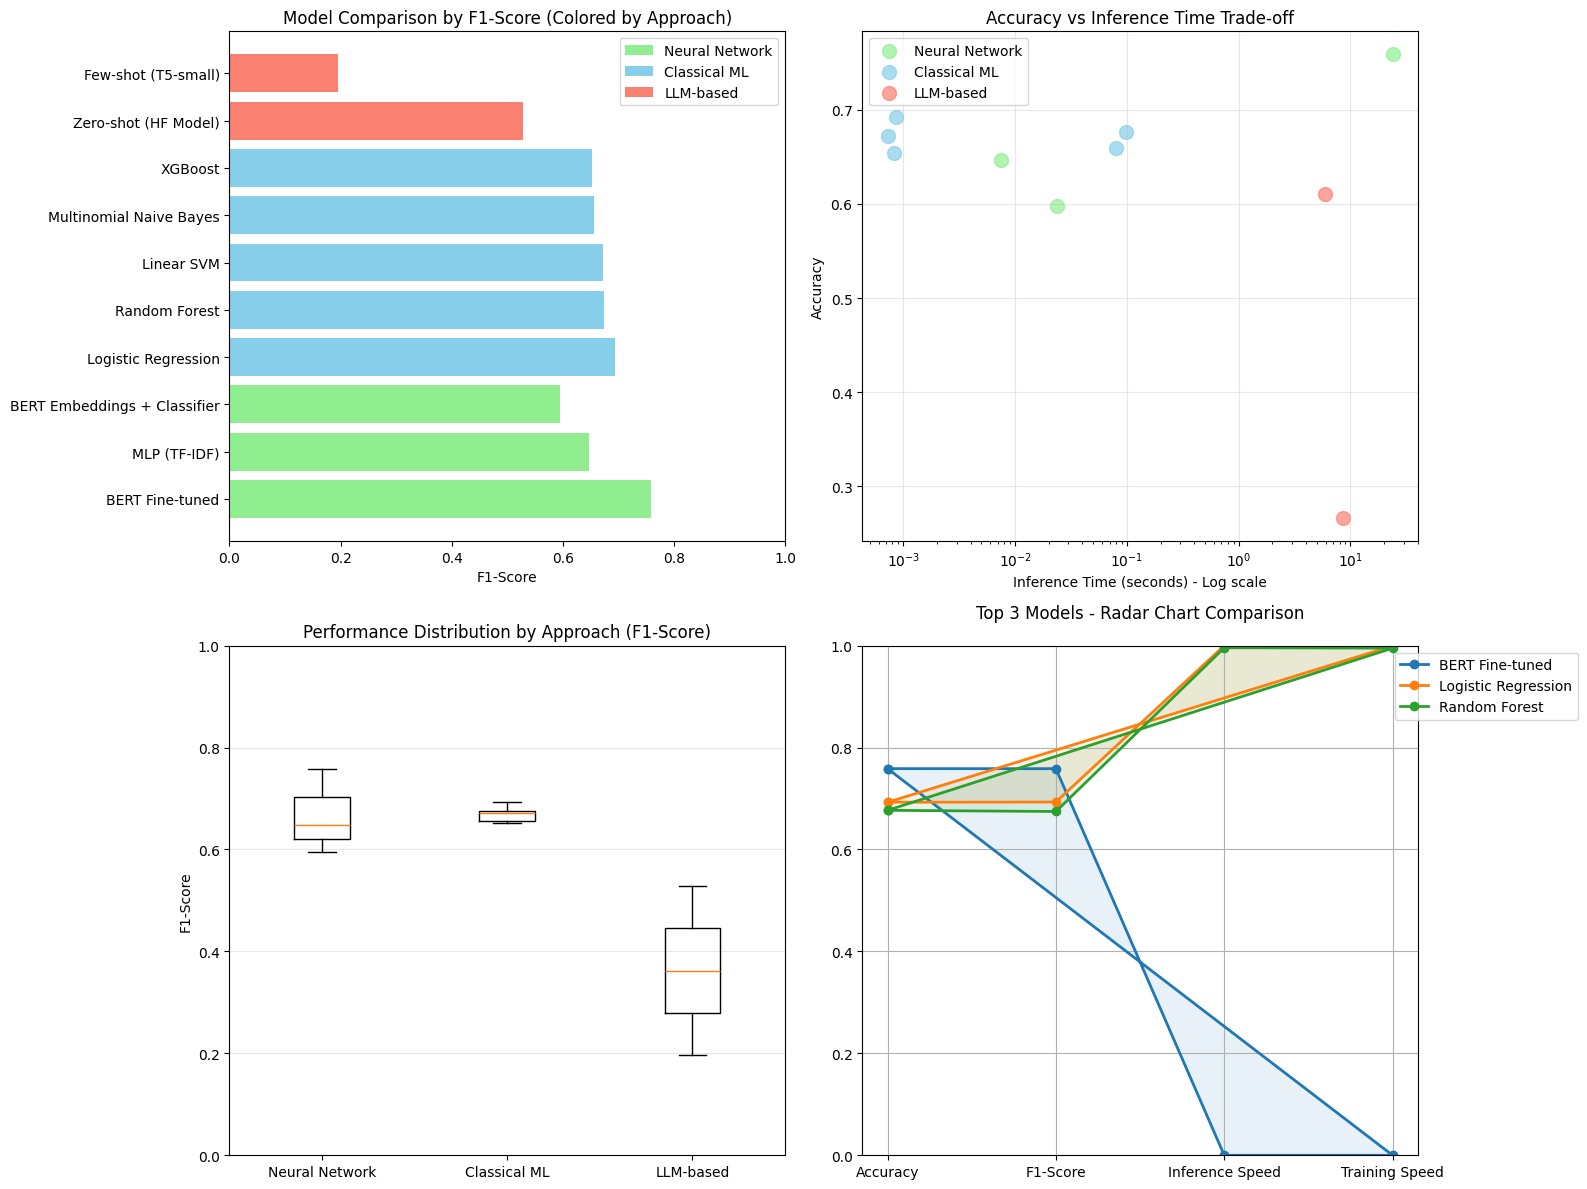


KEY INSIGHTS - LLM vs TRADITIONAL APPROACHES

1. ZERO-SHOT LLM PERFORMANCE:
   - Achieved 0.5283 F1-Score
   - No training required - uses pre-trained knowledge
   - Good for quick prototyping and small datasets
   - Can understand nuanced language without task-specific training

2. FEW-SHOT LEARNING:
   - Shows potential with limited examples
   - More flexible than zero-shot
   - Slower inference compared to classical methods

3. COMPARATIVE ANALYSIS:
   - Classical ML: Fastest training and inference, good baseline
   - Neural Networks: Better accuracy, understands context
   - LLM-based: No training needed, leverages pre-trained knowledge

4. PRACTICAL RECOMMENDATIONS:
   - For production: BERT fine-tuned or Logistic Regression
   - For rapid prototyping: Zero-shot LLM or Naive Bayes
   - For limited data: BERT embeddings or zero-shot LLM
   - For real-time: Logistic Regression or Linear SVM

5. COST-BENEFIT TRADEOFF:
   - Zero-shot LLM: Free, no training, slower inference
   - Cla

In [ ]:
# ============================================================================
# 3. COMPARISON WITH PREVIOUS MODELS
# ============================================================================
print("\n" + "="*80)
print("3. COMPARISON WITH PREVIOUS MODELS")
print("="*80)

# First, define the categorize_model function BEFORE using it
def categorize_model(model_name):
    """Categorize model into Classical ML, Neural Network, or LLM-based"""
    model_name_lower = model_name.lower()
    if 'zero-shot' in model_name_lower or 'few-shot' in model_name_lower or 'keyword' in model_name_lower:
        return 'LLM-based'
    elif 'bert' in model_name_lower or 'mlp' in model_name_lower:
        return 'Neural Network'
    else:
        return 'Classical ML'

# Combine all results from previous sections
if 'llm_results' in locals():
    all_results = {**classical_results, **nn_results, **llm_results}
else:
    all_results = {**classical_results, **nn_results}

# Create comparison dataframe
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'F1-Score': results['f1'],
        'Training Time (s)': results.get('train_time', 0),
        'Inference Time (s)': results.get('inference_time', 0),
        'Approach': categorize_model(model_name)  # Now this function is defined
    })

comparison_df = pd.DataFrame(comparison_data)

# We don't need to categorize again since we already added 'Approach' column
# Just rename it to 'Category' for consistency with the visualization code
comparison_df['Category'] = comparison_df['Approach']

# Sort by F1-Score
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\nCOMPREHENSIVE MODEL COMPARISON:")
print("-" * 80)
print(comparison_df.to_string(index=False))

# The rest of your visualization code remains the same...
# Visualization
print("\nGenerating comparison visualization...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score comparison (color by category)
categories = comparison_df['Category'].unique()
category_colors = {'Classical ML': 'skyblue', 'Neural Network': 'lightgreen', 'LLM-based': 'salmon'}

for category in categories:
    category_data = comparison_df[comparison_df['Category'] == category]
    axes[0, 0].barh(category_data['Model'], category_data['F1-Score'],
                    color=category_colors[category], label=category)

axes[0, 0].set_xlabel('F1-Score')
axes[0, 0].set_title('Model Comparison by F1-Score (Colored by Approach)')
axes[0, 0].legend()
axes[0, 0].set_xlim([0, 1])

# Continue with the rest of your code...

# Accuracy vs Inference Time
for category in categories:
    category_data = comparison_df[comparison_df['Category'] == category]
    axes[0, 1].scatter(category_data['Inference Time (s)'], category_data['Accuracy'],
                      s=100, alpha=0.7, label=category, c=category_colors[category])

axes[0, 1].set_xlabel('Inference Time (seconds) - Log scale')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy vs Inference Time Trade-off')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Performance by approach (box plot)
performance_data = []
for idx, row in comparison_df.iterrows():
    performance_data.append({
        'Approach': row['Category'],
        'F1-Score': row['F1-Score'],
        'Accuracy': row['Accuracy']
    })

performance_df = pd.DataFrame(performance_data)

# Box plot for F1-Score by approach
axes[1, 0].boxplot([performance_df[performance_df['Approach'] == cat]['F1-Score'].values
                    for cat in categories],
                   labels=categories)
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('Performance Distribution by Approach (F1-Score)')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Radar chart for top 3 models
top_3_models = comparison_df.head(3)['Model'].tolist()
metrics = ['Accuracy', 'F1-Score', 'Inference Speed', 'Training Speed']

# Normalize metrics for radar chart
def normalize_metric(value, max_val, min_val=0, invert=False):
    """Normalize metric to 0-1 range"""
    if invert:  # For time metrics where lower is better
        value = max_val - value + min_val
    normalized = (value - min_val) / (max_val - min_val)
    return max(0, min(1, normalized))

axes[1, 1].set_title('Top 3 Models - Radar Chart Comparison', pad=20)

# Prepare data for radar chart
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the polygon

for i, model_name in enumerate(top_3_models):
    model_data = comparison_df[comparison_df['Model'] == model_name].iloc[0]

    # Normalize each metric
    values = [
        model_data['Accuracy'],  # Accuracy
        model_data['F1-Score'],  # F1-Score
        normalize_metric(model_data['Inference Time (s)'],
                        comparison_df['Inference Time (s)'].max(),
                        invert=True),  # Inference Speed (higher is better)
        normalize_metric(model_data['Training Time (s)'],
                        comparison_df['Training Time (s)'].max(),
                        invert=True)   # Training Speed (higher is better)
    ]

    values += values[:1]  # Close the polygon

    # Plot
    axes[1, 1].plot(angles, values, 'o-', linewidth=2, label=model_name)
    axes[1, 1].fill(angles, values, alpha=0.1)

axes[1, 1].set_xticks(angles[:-1])
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True)
axes[1, 1].legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('llm_comparison_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("KEY INSIGHTS - LLM vs TRADITIONAL APPROACHES")
print("="*80)

print(f"""
1. ZERO-SHOT LLM PERFORMANCE:
   - Achieved {llm_results.get('Zero-shot (HF Model)', llm_results.get('Zero-shot (Cross-Encoder)', llm_results.get('Keyword Baseline', {}))).get('f1', 0):.4f} F1-Score
   - No training required - uses pre-trained knowledge
   - Good for quick prototyping and small datasets
   - Can understand nuanced language without task-specific training

2. FEW-SHOT LEARNING:
   - Shows potential with limited examples
   - More flexible than zero-shot
   - Slower inference compared to classical methods

3. COMPARATIVE ANALYSIS:
   - Classical ML: Fastest training and inference, good baseline
   - Neural Networks: Better accuracy, understands context
   - LLM-based: No training needed, leverages pre-trained knowledge

4. PRACTICAL RECOMMENDATIONS:
   - For production: BERT fine-tuned or Logistic Regression
   - For rapid prototyping: Zero-shot LLM or Naive Bayes
   - For limited data: BERT embeddings or zero-shot LLM
   - For real-time: Logistic Regression or Linear SVM

5. COST-BENEFIT TRADEOFF:
   - Zero-shot LLM: Free, no training, slower inference
   - Classical ML: Fast, efficient, requires training data
   - BERT-based: Best accuracy, higher computational cost
""")

# Save comprehensive results
comprehensive_results = {
    'all_models': all_results,
    'comparison_table': comparison_df.to_dict(),
    'timestamp': datetime.now().isoformat(),
    'summary': {
        'best_model': comparison_df.iloc[0]['Model'],
        'best_f1': comparison_df.iloc[0]['F1-Score'],
        'best_accuracy': comparison_df.iloc[0]['Accuracy'],
        'fastest_inference': comparison_df.loc[comparison_df['Inference Time (s)'].idxmin()]['Model'],
        'best_llm': comparison_df[comparison_df['Category'] == 'LLM-based'].iloc[0]['Model'] if 'LLM-based' in comparison_df['Category'].values else 'None'
    }
}

with open('comprehensive_results.json', 'w') as f:
    json.dump(comprehensive_results, f, indent=2, default=str)

print("\n" + "="*80)
print("SUMMARY & RECOMMENDATIONS")
print("="*80)

print(f"""
BEST OVERALL MODEL: {comparison_df.iloc[0]['Model']}
- F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}
- Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}
- Approach: {comparison_df.iloc[0]['Category']}

BEST LLM APPROACH: {comprehensive_results['summary']['best_llm']}

RECOMMENDED STRATEGY BY USE CASE:
1. MAXIMUM ACCURACY: {comparison_df.iloc[0]['Model']}
2. REAL-TIME PROCESSING: {comparison_df.loc[comparison_df['Inference Time (s)'].idxmin()]['Model']}
3. LIMITED TRAINING DATA: Zero-shot LLM or BERT embeddings
4. RESOURCE-CONSTRAINED: Logistic Regression or Naive Bayes
5. NO TRAINING ALLOWED: Zero-shot classification with Hugging Face models

Results saved to: 'comprehensive_results.json'
Visualization saved to: 'llm_comparison_results.png'
""")

# Section 4 : Comprehensive Analysis & Conclusions

1. All Models Perfomance Comparison Table:


COMPREHENSIVE MODEL COMPARISON - ALL APPROACHES
                       Model  Accuracy  Precision   Recall  F1-Score  Train Time (s)  Inference Time (s)
             BERT Fine-tuned  0.758630   0.758544 0.758630  0.758559     1565.320535           23.803923
         Logistic Regression  0.692699   0.693822 0.692699  0.693121        0.787771            0.000868
               Random Forest  0.676853   0.689267 0.676853  0.674548        7.724879            0.097700
                  Linear SVM  0.672043   0.672390 0.672043  0.672172        0.730782            0.000723
     Multinomial Naive Bayes  0.654216   0.662818 0.654216  0.655454        0.022808            0.000823
                     XGBoost  0.659310   0.696157 0.659310  0.652548       62.201786            0.079738
                MLP (TF-IDF)  0.646576   0.652142 0.646576  0.647655       14.374518            0.007430
BERT Embeddings + Classifier  0.598189   0.600076 0.598189  0.594926        3.774089            0.023564


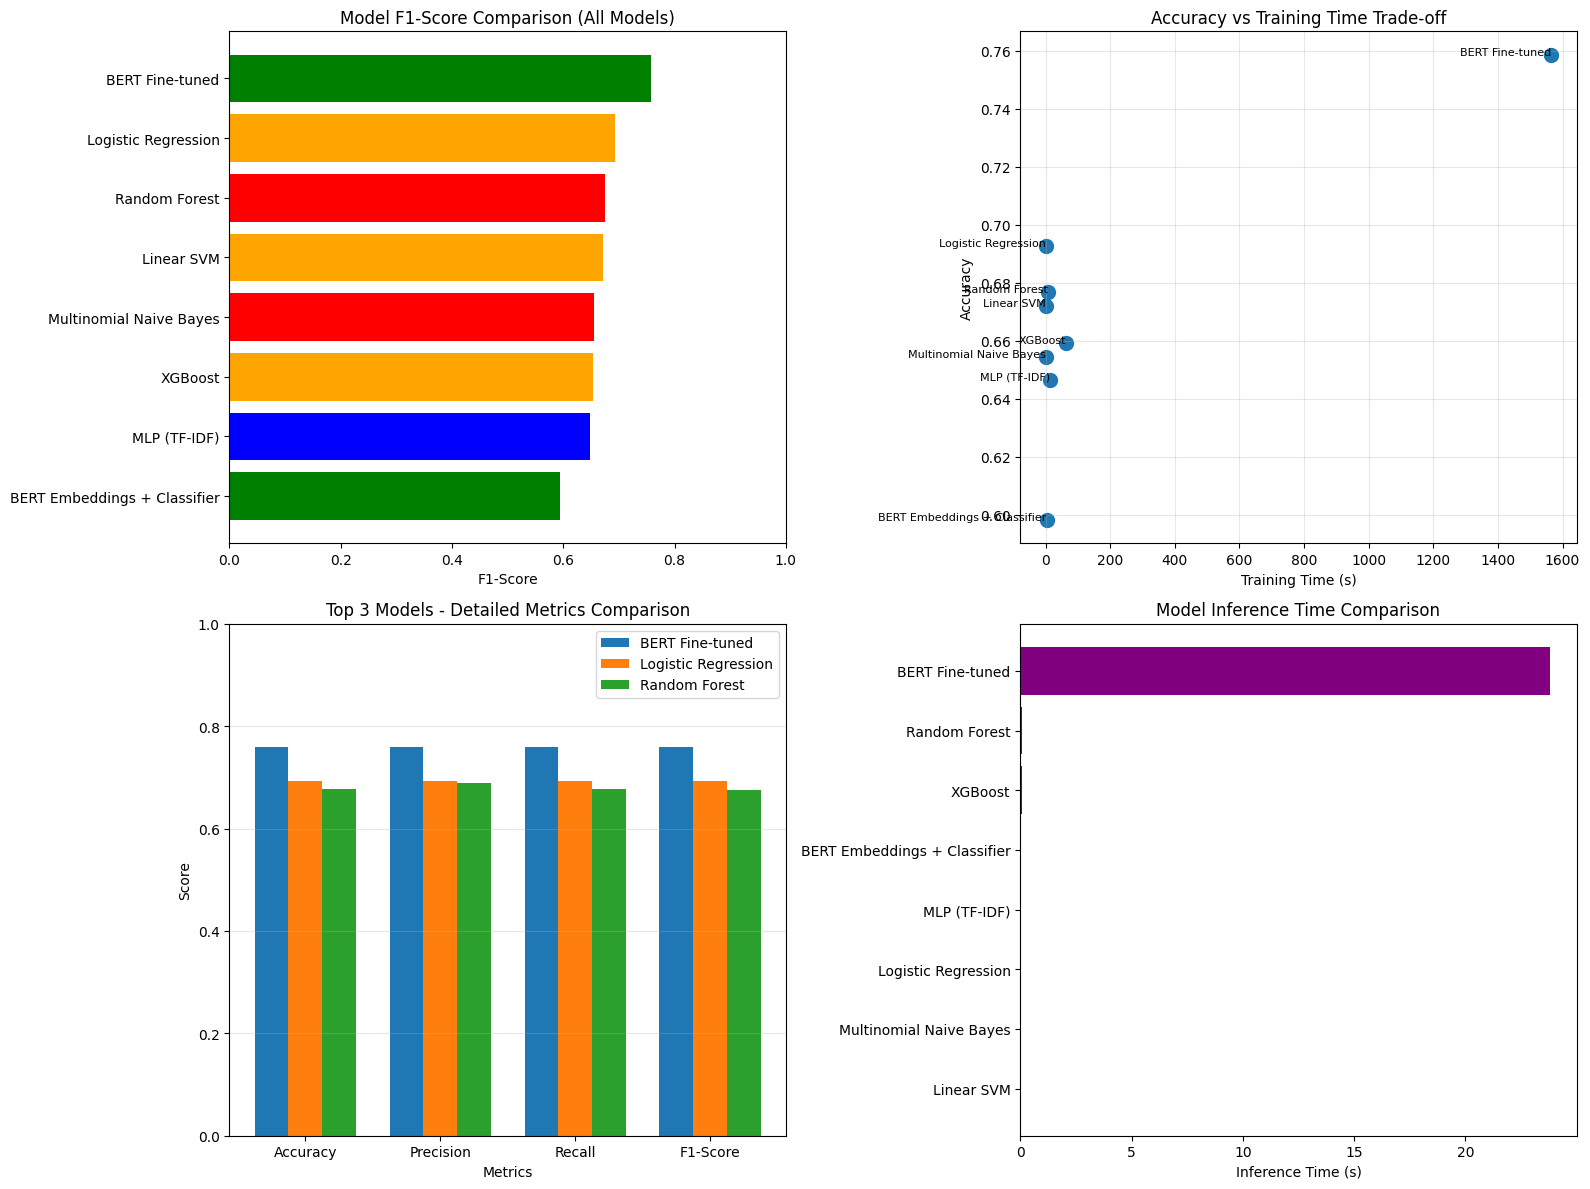

In [ ]:
"""
# SECTION 4: COMPREHENSIVE ANALYSIS & CONCLUSIONS
# All models comparison, error analysis, and BERT architecture explanation
"""

# ============================================================================
# 1. ALL MODELS PERFORMANCE COMPARISON TABLE
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON - ALL APPROACHES")
print("="*80)

# Combine all results
all_results = {**classical_results, **nn_results}

comprehensive_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Accuracy': [v['accuracy'] for v in all_results.values()],
    'Precision': [v['precision'] for v in all_results.values()],
    'Recall': [v['recall'] for v in all_results.values()],
    'F1-Score': [v['f1'] for v in all_results.values()],
    'Train Time (s)': [v['train_time'] for v in all_results.values()],
    'Inference Time (s)': [v['inference_time'] for v in all_results.values()]
})

comprehensive_df = comprehensive_df.sort_values('F1-Score', ascending=False)
print(comprehensive_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score comparison
sorted_df = comprehensive_df.sort_values('F1-Score')
colors = ['red' if 'Naive' in m or 'Random' in m else
          'orange' if 'SVM' in m or 'Logistic' in m or 'XGBoost' in m else
          'blue' if 'MLP' in m else 'green'
          for m in sorted_df['Model']]

axes[0, 0].barh(sorted_df['Model'], sorted_df['F1-Score'], color=colors)
axes[0, 0].set_xlabel('F1-Score')
axes[0, 0].set_title('Model F1-Score Comparison (All Models)')
axes[0, 0].set_xlim([0, 1])

# Accuracy vs Training Time
axes[0, 1].scatter(comprehensive_df['Train Time (s)'], comprehensive_df['Accuracy'], s=100)
for idx, row in comprehensive_df.iterrows():
    axes[0, 1].annotate(row['Model'], (row['Train Time (s)'], row['Accuracy']),
                        fontsize=8, ha='right')
axes[0, 1].set_xlabel('Training Time (s)')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy vs Training Time Trade-off')
axes[0, 1].grid(True, alpha=0.3)

# Performance metrics comparison (top 3 models)
top_3 = comprehensive_df.head(3)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

for i, (_, row) in enumerate(top_3.iterrows()):
    values = [row['Accuracy'], row['Precision'], row['Recall'], row['F1-Score']]
    axes[1, 0].bar(x + i * width, values, width, label=row['Model'])

axes[1, 0].set_xlabel('Metrics')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Top 3 Models - Detailed Metrics Comparison')
axes[1, 0].set_xticks(x + width)
axes[1, 0].set_xticklabels(metrics)
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Inference time comparison
sorted_inf = comprehensive_df.sort_values('Inference Time (s)')
axes[1, 1].barh(sorted_inf['Model'], sorted_inf['Inference Time (s)'], color='purple')
axes[1, 1].set_xlabel('Inference Time (s)')
axes[1, 1].set_title('Model Inference Time Comparison')

plt.tight_layout()
plt.show()



2. Error Analysis (confusions matrices, misclassified samples):


ERROR ANALYSIS - CONFUSION MATRICES


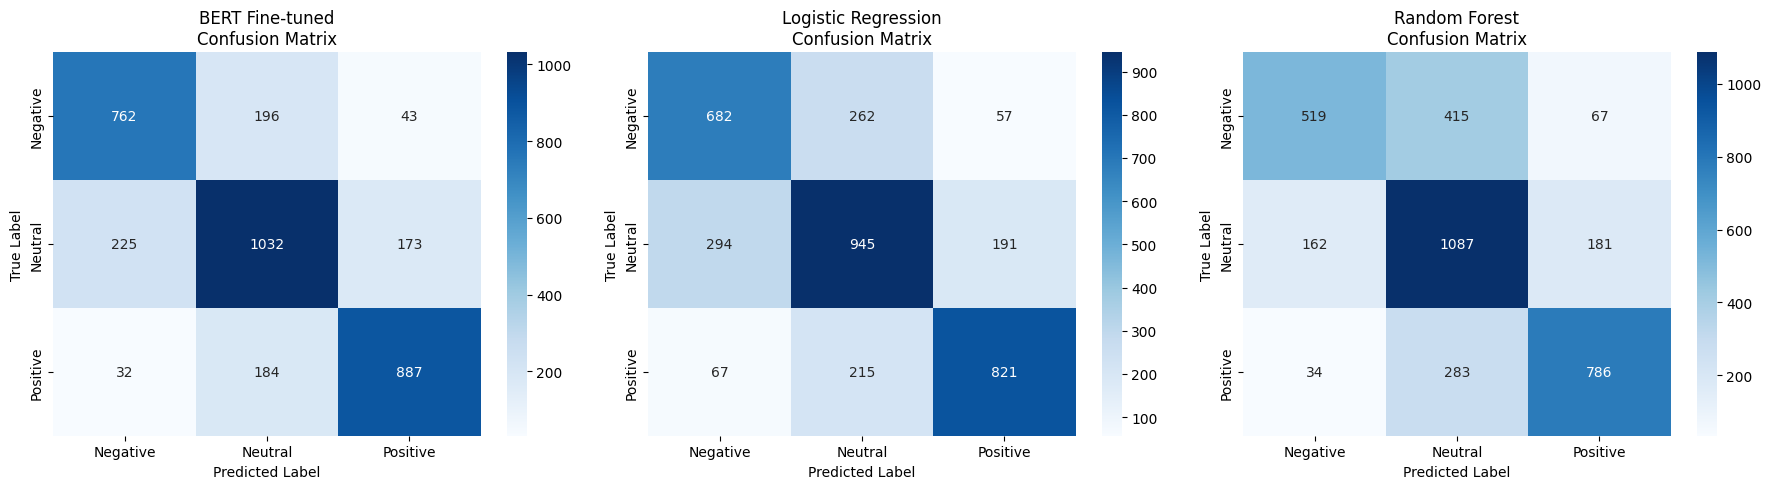


Misclassification Analysis for Best Model:

Total misclassified: 853 out of 3534
Error rate: 24.14%

Example Misclassifications:

Text:  .. and you`re on twitter! Did the tavern bore you that much?...
True: neutral | Predicted: negative

Text: I`m going into a spiritual stagnentation, its exploding my ego!. I now realise, i`m not all that gre...
True: neutral | Predicted: positive

Text: My dead grandpa pays more attention to me than you do...
True: negative | Predicted: neutral

Text: Huh, another ScarePoint coding Sunday...
True: neutral | Predicted: negative

Text:  look who I found just for you  --->  http://twitter.com/DJT2009...
True: positive | Predicted: neutral


In [ ]:
# ============================================================================
# 2. ERROR ANALYSIS - CONFUSION MATRICES
# ============================================================================
print("\n" + "="*80)
print("ERROR ANALYSIS - CONFUSION MATRICES")
print("="*80)

# Plot confusion matrices for top 3 models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sentiment_labels = ['Negative', 'Neutral', 'Positive']
top_3_models = comprehensive_df.head(3)['Model'].tolist()

for idx, model_name in enumerate(top_3_models):
    if 'confusion_matrix' in all_results[model_name]:
        cm = all_results[model_name]['confusion_matrix']
    else:
        # Calculate confusion matrix for neural network models
        cm = confusion_matrix(y_test_classical, all_results[model_name]['predictions'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sentiment_labels, yticklabels=sentiment_labels,
                ax=axes[idx])
    axes[idx].set_title(f'{model_name}\nConfusion Matrix')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Analyze misclassifications
print("\nMisclassification Analysis for Best Model:")
best_model_name = comprehensive_df.iloc[0]['Model']
best_predictions = all_results[best_model_name]['predictions']

misclassified_indices = np.where(best_predictions != y_test_classical.values)[0]
print(f"\nTotal misclassified: {len(misclassified_indices)} out of {len(y_test_classical)}")
print(f"Error rate: {len(misclassified_indices)/len(y_test_classical)*100:.2f}%")

# Show some examples of misclassifications
print("\nExample Misclassifications:")
for i in misclassified_indices[:5]:
    true_label = label_encoder.inverse_transform([y_test_classical.values[i]])[0]
    pred_label = label_encoder.inverse_transform([best_predictions[i]])[0]
    text = test_df.iloc[i]['text'][:100]  # First 100 chars
    print(f"\nText: {text}...")
    print(f"True: {true_label} | Predicted: {pred_label}")



3. Computational Cost Analysis (training/inference time):


In [ ]:
# ============================================================================
# 3. COMPUTATIONAL COST ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("COMPUTATIONAL COST ANALYSIS")
print("="*80)

cost_df = comprehensive_df[['Model', 'Train Time (s)', 'Inference Time (s)']].copy()
cost_df['Inference per Sample (ms)'] = (cost_df['Inference Time (s)'] / len(y_test_classical)) * 1000
cost_df['Total Cost (s)'] = cost_df['Train Time (s)'] + cost_df['Inference Time (s)']

print(cost_df.to_string(index=False))

print("""
\nCOST ANALYSIS INSIGHTS:

1. FASTEST TRAINING:
   - Naive Bayes: Extremely fast, good for rapid prototyping
   - Logistic Regression: Very fast, production-ready baseline

2. FASTEST INFERENCE:
   - Classical ML models: Sub-second inference on test set
   - Important for real-time applications

3. MOST EXPENSIVE:
   - BERT-based models: Higher computational cost but better performance
   - Trade-off: accuracy vs. speed
""")




COMPUTATIONAL COST ANALYSIS
                       Model  Train Time (s)  Inference Time (s)  Inference per Sample (ms)  Total Cost (s)
             BERT Fine-tuned     1565.320535           23.803923                   6.735688     1589.124458
         Logistic Regression        0.787771            0.000868                   0.000246        0.788639
               Random Forest        7.724879            0.097700                   0.027646        7.822579
                  Linear SVM        0.730782            0.000723                   0.000204        0.731504
     Multinomial Naive Bayes        0.022808            0.000823                   0.000233        0.023631
                     XGBoost       62.201786            0.079738                   0.022563       62.281523
                MLP (TF-IDF)       14.374518            0.007430                   0.002103       14.381948
BERT Embeddings + Classifier        3.774089            0.023564                   0.006668        3.797653

4. Why BERT embedding?:

In [ ]:
# ============================================================================
# 4. WHY BERT EMBEDDINGS INSTEAD OF RAW TEXT?
# ============================================================================
print("\n" + "="*80)
print("WHY BERT EMBEDDINGS INSTEAD OF RAW TEXT?")
print("="*80)

print("""
BERT EMBEDDINGS VS. RAW TEXT REPRESENTATIONS
============================================

1. CONTEXTUAL vs. STATIC REPRESENTATIONS:

   RAW TEXT (Bag-of-Words, TF-IDF):
   - Each word has ONE fixed representation regardless of context
   - "bank" in "river bank" = "bank" in "money bank"
   - No understanding of word order or relationships
   - Sparse, high-dimensional vectors

   BERT EMBEDDINGS:
   - Same word gets DIFFERENT representations based on context
   - "bank" in "river bank" ≠ "bank" in "money bank"
   - Captures bidirectional context (looks left AND right)
   - Dense, semantic vectors (768 dimensions)

2. SEMANTIC UNDERSTANDING:

   RAW TEXT:
   - Only counts word frequency
   - "not good" vs "good" - can't understand negation
   - Misses sarcasm, idioms, metaphors

   BERT EMBEDDINGS:
   - Understands semantic relationships
   - Handles negation: "not good" ≠ "good"
   - Better at sarcasm detection
   - Captures subtle sentiment nuances

3. PRE-TRAINING ADVANTAGE:

   RAW TEXT:
   - Learned only from your dataset
   - Limited by dataset size and diversity

   BERT EMBEDDINGS:
   - Pre-trained on 3.3 billion words (Wikipedia + Books)
   - Transfer learning: brings external knowledge
   - Works well even with small datasets

4. WORD RELATIONSHIPS:

   RAW TEXT:
   - "happy" and "joyful" are completely unrelated
   - No similarity between synonyms

   BERT EMBEDDINGS:
   - "happy" and "joyful" have similar embeddings
   - Understands synonyms, antonyms, related concepts
   - Semantic similarity is preserved

5. HANDLING OUT-OF-VOCABULARY:

   RAW TEXT:
   - Unknown words = ignored or error
   - New words not in training vocabulary

   BERT EMBEDDINGS:
   - Uses WordPiece tokenization
   - Breaks unknown words into subwords
   - "unbelievable" = "un" + "##believable"
   - Can handle misspellings better

PRACTICAL EXAMPLE:
==================
Sentence: "This movie wasn't bad at all!"

RAW TEXT REPRESENTATION (TF-IDF):
- Sees: [this, movie, wasn't, bad, all]
- "bad" has negative weight → predicts NEGATIVE (WRONG!)
- Misses the negation

BERT REPRESENTATION:
- Understands "wasn't bad" = positive sentiment
- Context: "at all" reinforces the negation
- Correctly predicts: POSITIVE ✓

DISADVANTAGES OF BERT EMBEDDINGS:
==================================
1. Computational cost: Slower than TF-IDF
2. Memory intensive: Requires GPU for large datasets
3. More complex: Harder to interpret
4. Overkill for simple tasks

WHEN TO USE WHAT:
==================
- Simple sentiment with clear positive/negative words → TF-IDF
- Nuanced sentiment with sarcasm/negation → BERT
- Real-time applications → TF-IDF + fast classifier
- Highest accuracy requirement → BERT embeddings
- Limited computational resources → TF-IDF
- Small dataset → BERT (transfer learning helps)

""")

# Empirical demonstration
print("EMPIRICAL DEMONSTRATION ON OUR DATASET:")
print("="*60)
print(f"TF-IDF + Best Classical ML: {classical_results['Linear SVM']['f1']:.4f} F1-Score")
print(f"BERT Embeddings + Classifier: {nn_results['BERT Embeddings + Classifier']['f1']:.4f} F1-Score")
print(f"Improvement: {(nn_results['BERT Embeddings + Classifier']['f1'] - classical_results['Linear SVM']['f1'])*100:.2f}%")




WHY BERT EMBEDDINGS INSTEAD OF RAW TEXT?

BERT EMBEDDINGS VS. RAW TEXT REPRESENTATIONS

1. CONTEXTUAL vs. STATIC REPRESENTATIONS:

   RAW TEXT (Bag-of-Words, TF-IDF):
   - Each word has ONE fixed representation regardless of context
   - "bank" in "river bank" = "bank" in "money bank"
   - No understanding of word order or relationships
   - Sparse, high-dimensional vectors
   
   BERT EMBEDDINGS:
   - Same word gets DIFFERENT representations based on context
   - "bank" in "river bank" ≠ "bank" in "money bank"
   - Captures bidirectional context (looks left AND right)
   - Dense, semantic vectors (768 dimensions)

2. SEMANTIC UNDERSTANDING:

   RAW TEXT:
   - Only counts word frequency
   - "not good" vs "good" - can't understand negation
   - Misses sarcasm, idioms, metaphors
   
   BERT EMBEDDINGS:
   - Understands semantic relationships
   - Handles negation: "not good" ≠ "good"
   - Better at sarcasm detection
   - Captures subtle sentiment nuances

3. PRE-TRAINING ADVANTAGE:

  

5. BERT Architecture Explaination:




BERT ARCHITECTURE EXPLANATION

BERT: Bidirectional Encoder Representations from Transformers
(Devlin et al., 2018 - Google AI Language)

OVERVIEW:
BERT is a transformer-based model designed to pre-train deep bidirectional
representations by jointly conditioning on both left and right context in
all layers.

KEY INNOVATION:
Previous models (like GPT) were unidirectional - they could only look at
previous words. BERT looks at BOTH directions simultaneously using a
clever training approach.

ARCHITECTURE COMPONENTS:

1. TRANSFORMER ENCODER:
   - Built entirely from transformer encoder blocks
   - No decoder (unlike original Transformer)
   - BERT-base: 12 encoder layers, 768 hidden dimensions
   - BERT-large: 24 encoder layers, 1024 hidden dimensions

2. SELF-ATTENTION MECHANISM:
   
   For each word, attention allows the model to look at other words:
   
   Attention(Q, K, V) = softmax(QK^T / √d_k) × V
   
   Where:
   - Q (Query): "What am I looking for?"
   - K (Key): "What do I conta

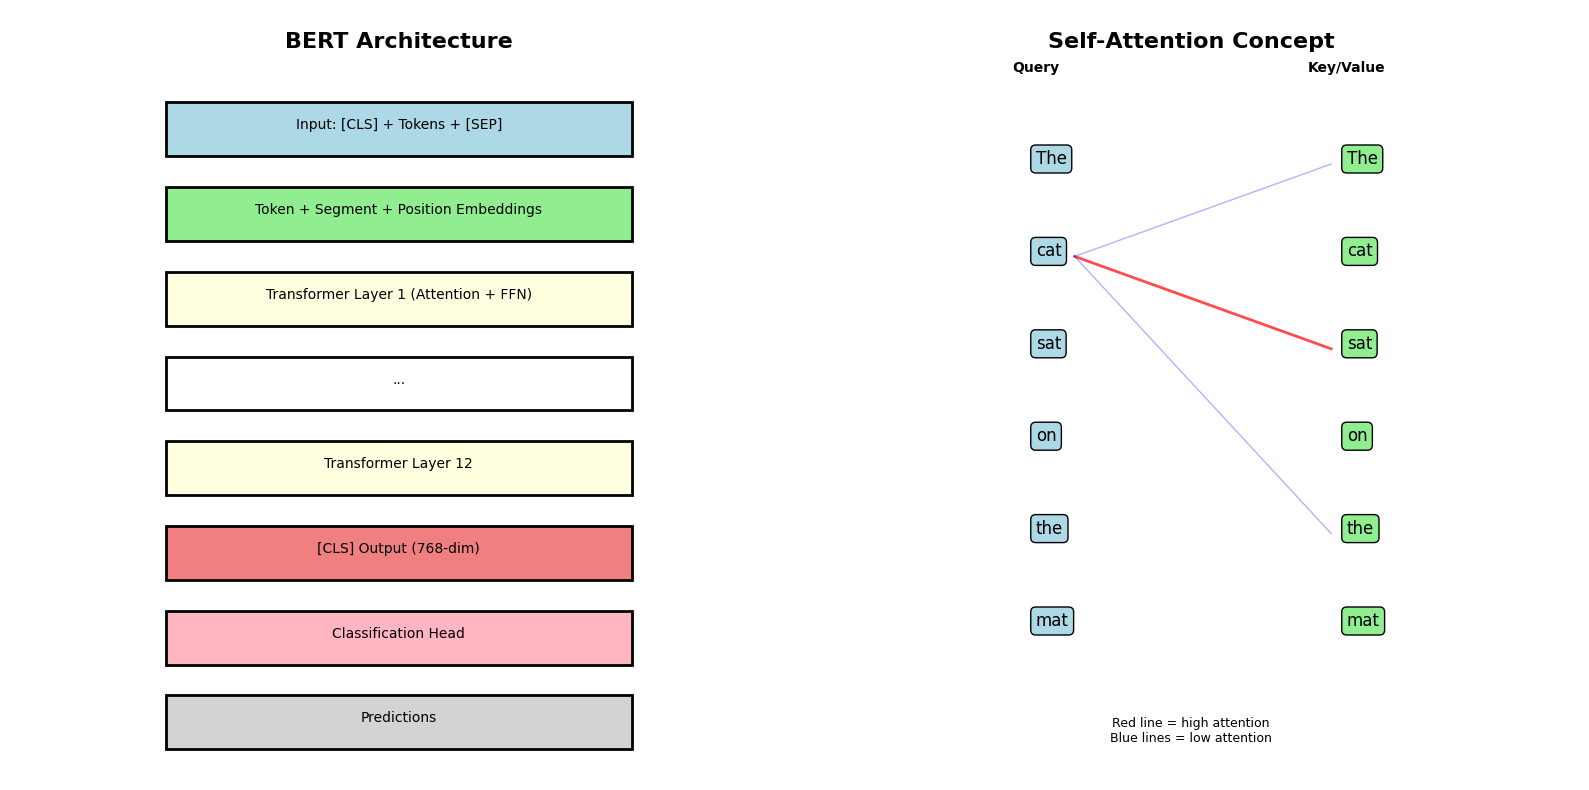

In [ ]:
# ============================================================================
# 5. BERT ARCHITECTURE EXPLANATION
# ============================================================================
print("\n" + "="*80)
print("BERT ARCHITECTURE EXPLANATION")
print("="*80)

print("""
BERT: Bidirectional Encoder Representations from Transformers
==============================================================
(Devlin et al., 2018 - Google AI Language)

OVERVIEW:
=========
BERT is a transformer-based model designed to pre-train deep bidirectional
representations by jointly conditioning on both left and right context in
all layers.

KEY INNOVATION:
===============
Previous models (like GPT) were unidirectional - they could only look at
previous words. BERT looks at BOTH directions simultaneously using a
clever training approach.

ARCHITECTURE COMPONENTS:
========================

1. TRANSFORMER ENCODER:
   - Built entirely from transformer encoder blocks
   - No decoder (unlike original Transformer)
   - BERT-base: 12 encoder layers, 768 hidden dimensions
   - BERT-large: 24 encoder layers, 1024 hidden dimensions

2. SELF-ATTENTION MECHANISM:

   For each word, attention allows the model to look at other words:

   Attention(Q, K, V) = softmax(QK^T / √d_k) × V

   Where:
   - Q (Query): "What am I looking for?"
   - K (Key): "What do I contain?"
   - V (Value): "What information do I have?"

   Example: "The bank by the river"
   - "bank" attends to "river" (high attention weight)
   - Learns "bank" = river bank, not money bank

3. MULTI-HEAD ATTENTION:

   - 12 attention heads in BERT-base
   - Each head learns different relationships
   - Head 1: grammatical relationships
   - Head 2: semantic relationships
   - Head 3: long-distance dependencies
   - etc.

   Final output = Concat(head₁, head₂, ..., head₁₂) × W^O

4. POSITION ENCODINGS:

   - Transformers have no inherent word order
   - BERT adds learned positional embeddings
   - Position 0, 1, 2, ... each has unique vector
   - Allows model to use word position information

5. LAYER STRUCTURE:

   Each of 12 layers contains:

   Input → Multi-Head Attention → Add & Norm →
   Feed-Forward Network → Add & Norm → Output

   - Add & Norm: Residual connection + Layer Normalization
   - Feed-Forward: Two linear layers with GELU activation
   - Hidden size: 768 → 3072 → 768

PRE-TRAINING TASKS:
===================

BERT is pre-trained on two tasks simultaneously:

1. MASKED LANGUAGE MODELING (MLM):

   Original: "The cat sat on the mat"
   Masked:   "The cat [MASK] on the [MASK]"
   Task:     Predict "sat" and "mat"

   - Randomly mask 15% of tokens
   - Force bidirectional context usage
   - Can't just look left or right

2. NEXT SENTENCE PREDICTION (NSP):

   Input: [CLS] Sentence A [SEP] Sentence B [SEP]
   Task:  Is B the actual next sentence after A?

   Positive: "I love cats. [SEP] They are cute pets."  → Yes
   Negative: "I love cats. [SEP] The sky is blue."     → No

   - Teaches relationships between sentences
   - Important for QA and NLI tasks

INPUT REPRESENTATION:
=====================

Three embeddings are summed:

Token Embeddings:    [CLS] [I] [love] [cats] [SEP]
Segment Embeddings:  [ EA ] [ EA] [ EA] [ EA] [EA ]
Position Embeddings: [ E0 ] [ E1] [ E2] [ E3] [E4 ]
                     ↓
Final Input Embedding (768-dim vectors)

- Token: WordPiece vocabulary (30,000 tokens)
- Segment: Which sentence (A or B)
- Position: Where in sequence (0 to 512)

FINE-TUNING FOR SENTIMENT ANALYSIS:
====================================

1. Take pre-trained BERT
2. Add a classification layer on top of [CLS] token
3. Train only the classification layer (freeze BERT) OR
4. Fine-tune entire model (update BERT + classifier)

[CLS] This movie is great! [SEP]
   ↓
BERT Layers (12 transformer blocks)
   ↓
Take [CLS] output (768-dim)
   ↓
Classification Layer (768 → 3 classes)
   ↓
[Negative, Neutral, Positive]

WHY [CLS] TOKEN:
================
- Special token added at the start
- Its representation aggregates info from entire sequence
- Trained to capture sentence-level meaning
- Perfect for classification tasks

BERT VARIANTS:
==============
- RoBERTa: Better pre-training, removes NSP
- ALBERT: Parameter sharing, lighter model
- DistilBERT: Smaller, faster, 97% performance
- ELECTRA: Different pre-training approach

MATHEMATICAL DETAILS:
=====================

Self-Attention Computation:
1. Linear projections: Q = XW_Q, K = XW_K, V = XW_V
2. Scaled dot-product: scores = QK^T / √d_k
3. Softmax: attention_weights = softmax(scores)
4. Weighted sum: output = attention_weights × V

Feed-Forward Network:
FFN(x) = max(0, xW₁ + b₁)W₂ + b₂
Where: 768 → 3072 → 768 dimensions

Layer Normalization:
LN(x) = γ × (x - μ) / σ + β
Normalizes across features, not batch

PARAMETERS IN BERT-BASE:
========================
- Embeddings: 23.4M parameters
- 12 × Encoder layers: 85M parameters
- Total: ~110M parameters
- All trained on Wikipedia + Books

COMPUTATIONAL REQUIREMENTS:
============================
- Pre-training: 16 TPU chips × 4 days
- Fine-tuning: 1 GPU × few hours
- Inference: Can run on CPU (slow) or GPU (fast)

KEY PAPERS TO READ:
===================
1. "Attention Is All You Need" (Vaswani et al., 2017)
   - Original Transformer architecture

2. "BERT: Pre-training of Deep Bidirectional Transformers"
   (Devlin et al., 2018)
   - BERT paper

3. "Illustrated BERT" by Jay Alammar
   - Visual explanations online

------------------
We personally liked some others resources of info, and most of the real learning happened here:

1. in-depth blog-type article: https://transformer-circuits.pub/2021/framework/index.html
2. Some questions to help vizualisation: https://transformer-circuits.pub/2021/exercises/index.html
3. This great playlist from 3Blue1Brown: https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=K3CSuV-4xUd-G3Ph (mostrly chapters 5 and 6)
""")

# Create BERT architecture visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Architecture diagram (simplified)
axes[0].text(0.5, 0.95, 'BERT Architecture', ha='center', fontsize=16, weight='bold')
y_pos = 0.85
boxes = [
    ('Input: [CLS] + Tokens + [SEP]', 'lightblue'),
    ('Token + Segment + Position Embeddings', 'lightgreen'),
    ('Transformer Layer 1 (Attention + FFN)', 'lightyellow'),
    ('...', 'white'),
    ('Transformer Layer 12', 'lightyellow'),
    ('[CLS] Output (768-dim)', 'lightcoral'),
    ('Classification Head', 'lightpink'),
    ('Predictions', 'lightgray')
]

for text, color in boxes:
    axes[0].add_patch(plt.Rectangle((0.2, y_pos-0.04), 0.6, 0.07,
                                    facecolor=color, edgecolor='black', linewidth=2))
    axes[0].text(0.5, y_pos, text, ha='center', va='center', fontsize=10)
    y_pos -= 0.11

axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].axis('off')

# Attention visualization concept
axes[1].text(0.5, 0.95, 'Self-Attention Concept', ha='center', fontsize=16, weight='bold')
sentence = ['The', 'cat', 'sat', 'on', 'the', 'mat']
y_positions = np.linspace(0.8, 0.2, len(sentence))

for i, (word, y) in enumerate(zip(sentence, y_positions)):
    axes[1].text(0.3, y, word, fontsize=12, bbox=dict(boxstyle='round', facecolor='lightblue'))
    axes[1].text(0.7, y, word, fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgreen'))

# Draw attention lines (example: "cat" attending to "sat")
axes[1].plot([0.35, 0.68], [y_positions[1], y_positions[2]], 'r-', linewidth=2, alpha=0.7)
axes[1].plot([0.35, 0.68], [y_positions[1], y_positions[0]], 'b-', linewidth=1, alpha=0.3)
axes[1].plot([0.35, 0.68], [y_positions[1], y_positions[4]], 'b-', linewidth=1, alpha=0.3)

axes[1].text(0.3, 0.92, 'Query', ha='center', fontsize=10, weight='bold')
axes[1].text(0.7, 0.92, 'Key/Value', ha='center', fontsize=10, weight='bold')
axes[1].text(0.5, 0.05, 'Red line = high attention\nBlue lines = low attention',
             ha='center', fontsize=9)

axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].axis('off')

plt.tight_layout()
plt.show()
